In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]
twilight = colormaps["twilight"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
twilight.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    ["/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    EXPOSURE=[str(i + 1) for i in range(5)],  # Which sub-pixel position
    **kwargs,
)

files = [] + file_fn(FILTER="F380M") + file_fn(FILTER="F430M") + file_fn(FILTER="F480M")

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS", "EXPOSURE"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



15
  TARGPROP: HD-41094
  FILTER: F380M, F480M, F430M
  NINTS: 760, 905, 1060
  NGROUPS: 11, 20, 30
  OBSERVTN: 001
  NCHUNKS: 1
  EXPOSURE: 3, 4, 1, 5, 2


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

In [4]:
from amigo.model_fits import SplineVisFit, FringeFit

class FringedVisFit(SplineVisFit, FringeFit):

    # NOTE: This is hacky, there should be a better class inheritance way to do this
    def get_key(self, exposure, param):
        if param in ["shifts", "contrasts"]:
            return exposure.filter
        
        if param in ["amplitudes", "phases"]:
            if not self.joint_fit:
                if param in ["amplitudes", "phases"]:
                    return exposure.key
        return super().get_key(exposure, param)
        

    def __call__(self, model, exposure):
        psf = self.model_psf(model, exposure)
        psf = self.model_vis(psf, model, exposure)
        psf = self.model_detector(psf, model, exposure)
        ramp = self.model_ramp(psf, model, exposure)
        return self.model_read(ramp, model, exposure)

In [5]:
import jax.numpy as np
from zodiax.experimental import deserialise
from amigo.files import repopulate
from amigo.core_models import AmigoModel
from amigo.optical_models import AMIOptics
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.vis_models import SplineVis
from amigo.files import get_exposures, initialise_params

optics = AMIOptics()
vis_model = SplineVis(optics, x_osamp=3, y_osamp=2)
detector = LinearDetectorModel()
ramp_model = PolyNonLin(orders=[2], norm=1e-3)
read_model = ReadModel()

# Prep the model
fit = FringedVisFit(joint_fit=False)
exposures = get_exposures(files, fit)
params = initialise_params(
    exposures, optics, fit_fringes=True, vis_model=vis_model
)

# Add the binary parameters
model = AmigoModel(
    files,
    params,
    optics=optics,
    detector=detector,
    ramp=ramp_model,
    read=read_model,
    visibilities=vis_model,
)

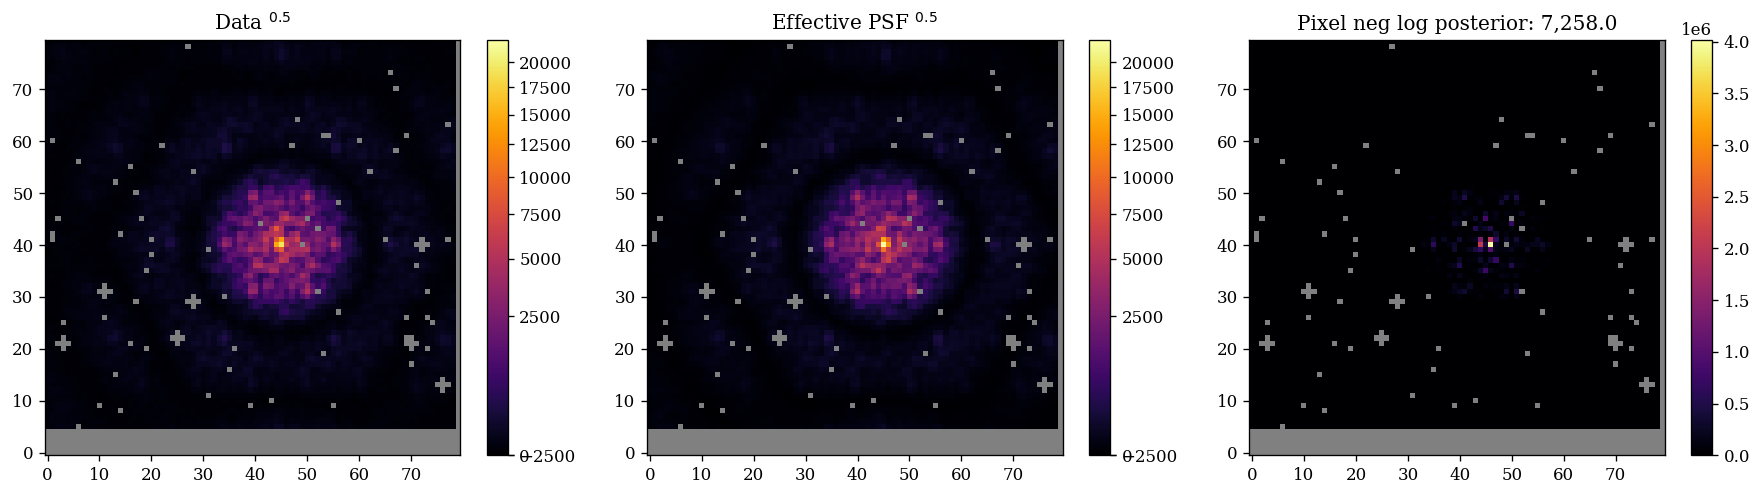

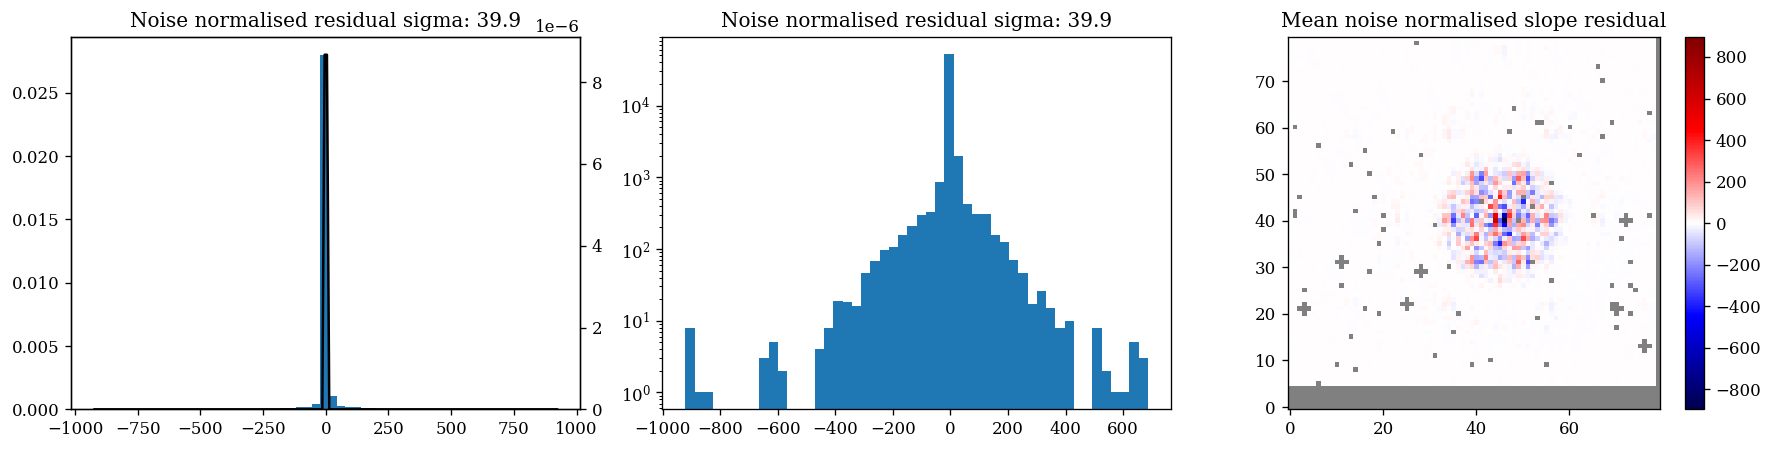

In [6]:
from amigo.plotting import summarise_fit

summarise_fit(exposures[0], model, residuals=True, histograms=True)

In [7]:
from amigo.fisher import calc_fishers

params = [
    "positions",
    "aberrations",
    "fluxes",
    "rotation",
    "compression",
    "shear",
    "f2f",
    "holes",
    "dark_current",
    "jitter.r",
    "anisotropy.compression",
    "amplitudes",
    "phases",
    "shifts",
    "contrasts",
]
model = model.set("ramp", None)
fishers = calc_fishers(model, exposures, params, overwrite=True)
model = model.set("ramp", ramp_model)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

2024-07-23 02:14:54.355391: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2618, f64[] %constant.194), window={size=1x32x32 stride=1x32x32}, to_apply=%region_1.135

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-07-23 02:14:54.538784: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.194072s
Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2618, f64[] %constant.194), window={size=1

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
def grad_fn(model, grads, args, key):
    if grads.holes is not None:
        grads = grads.set("holes", grads.holes * np.ones((7, 2)).at[:3, :].set(0))
    return grads, key


def norm_fn(model, model_params, args, key):

    # Randomly perturb the ramp values, note the scale should probably be determined
    # by the variance of the present coefficient distribution for each order
    if "ramp.coeffs" in model_params.params.keys():
        params = model_params.params
        key, subkey = jr.split(key, 2)
        vals = model_params.params["ramp.coeffs"]
        vals += 1e-7 * jr.normal(subkey, vals.shape)
        params["ramp.coeffs"] = vals
        model_params = model_params.set("params", params)

    # Normalise the pupil mask compression to have a mean of 1
    if "compression" in model_params.params.keys():
        params = model_params.params
        comp = params["compression"]
        comp -= comp.mean()
        params["compression"] = comp + 1
        model_params = model_params.set("params", params)

    # Normalise the pixel scale compression to have a mean of 1
    if "anisotropy.compression" in model_params.params.keys():
        params = model_params.params
        comp = params["anisotropy.compression"]
        comp -= comp.mean()
        params["anisotropy.compression"] = comp + 1
        model_params = model_params.set("params", params)
    return model_params, key

In [10]:
from amigo.fitting import optimise, sgd
import jax.random as jr

batch_size = 3
exposures_in = exposures
if batch_size > len(exposures_in):
    batch_size = len(exposures_in)
nbatch = len(exposures_in) // batch_size
if len(exposures_in) % batch_size != 0:
    nbatch += 1

optimisers = {
    "positions": sgd(5e-1, 0),
    "aberrations": sgd(1e-1, 5),
    "fluxes": sgd(2e-1, 10),
    "dark_current": sgd(2e-1, 10),
    "ramp.coeffs.2": sgd(1e1 / batch_size, 15 * nbatch),
    "f2f": sgd(2e-1, 20),
    "holes": sgd(5e-1, 20),
    "anisotropy.compression": sgd(5e-2, 25),
    "jitter.r": sgd(5e-1, 25),
    "shear": sgd(2e-1, 30),
    "rotation": sgd(1e-1, 30),
    "compression": sgd(2e-1, 30),
    "shifts": sgd(2e-3, 35),
    "contrasts": sgd(2e-3, 40),
    "amplitudes": sgd(2e-2, 80),
    "phases": sgd(2e-2, 80),
}

# Optimisation
final_model, losses, histories, states = optimise(
    model,
    exposures_in,
    optimisers,
    epochs=250,
    key=jr.PRNGKey(0),
    fishers=fishers,
    grad_fn=grad_fn,
    norm_fn=norm_fn,
    print_grads=False,
    batch_size=batch_size,
    batch_params=["ramp.coeffs.2"],
)

  0%|          | 0/250 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Compiling update function
Compile Time: 0:04:15
Initial Loss: 15,919.64
Est time per epoch:  0:01:41
Est run remaining:  7:05:57
Full Time: 6:46:41
Final Loss: 71.94


71.93751688461855 [73.62997534 67.17045117 74.93689806 69.20356174 74.74669811]


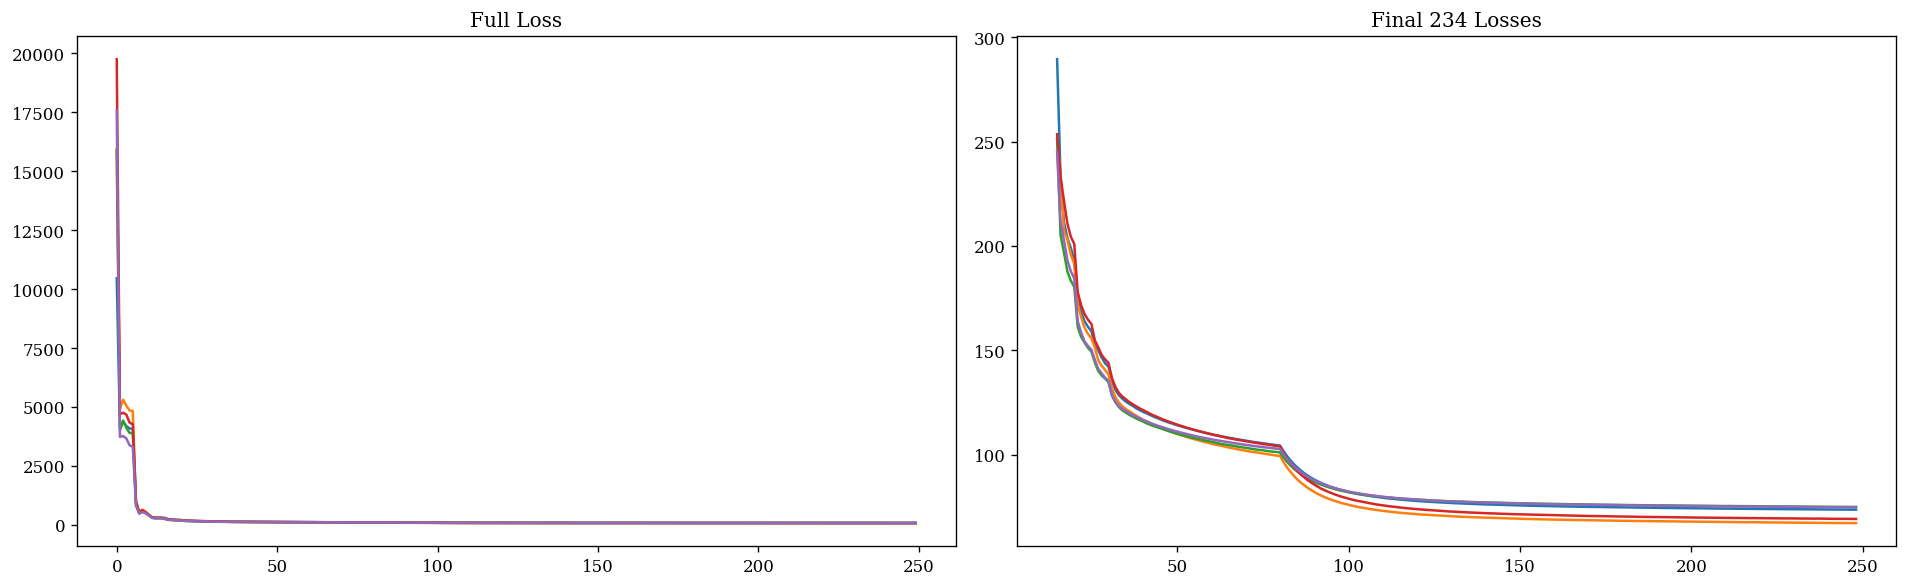

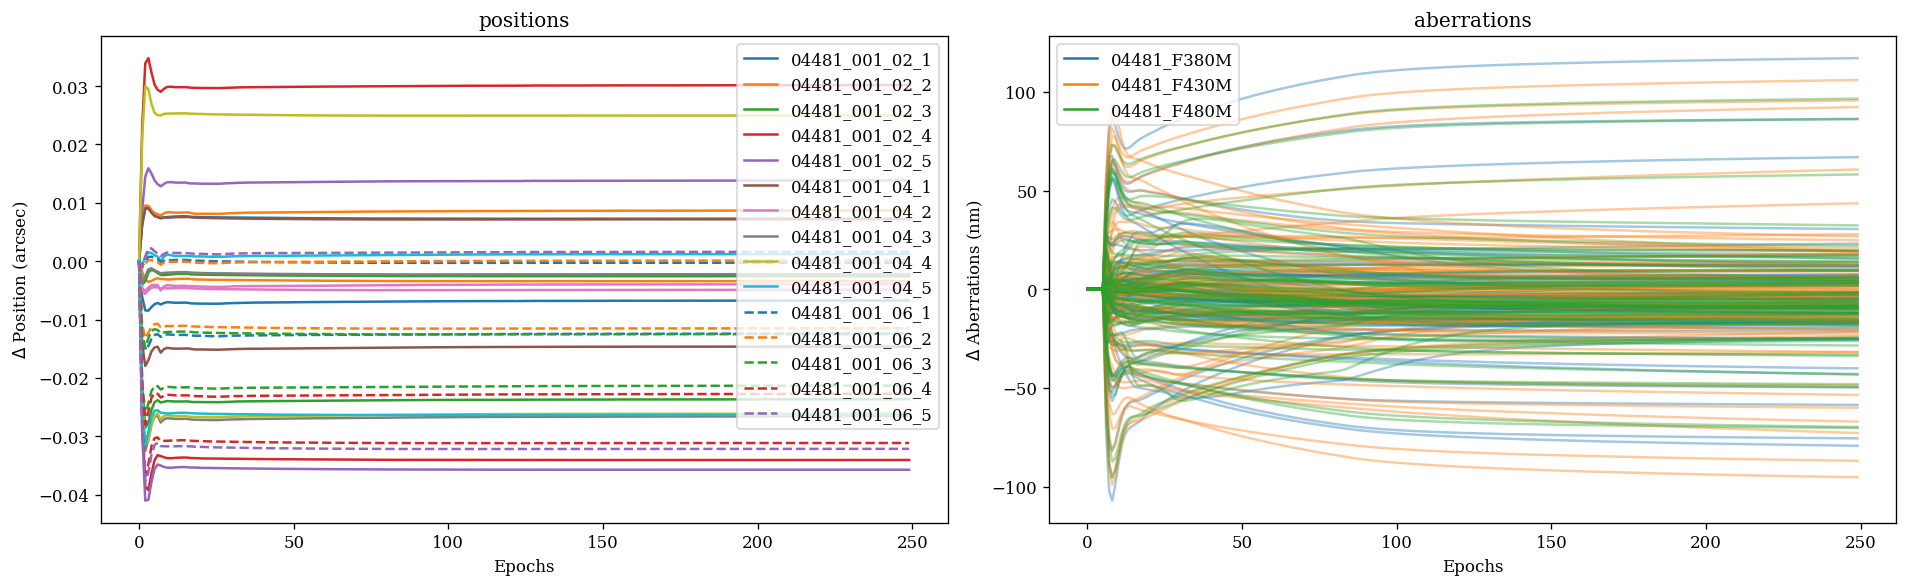

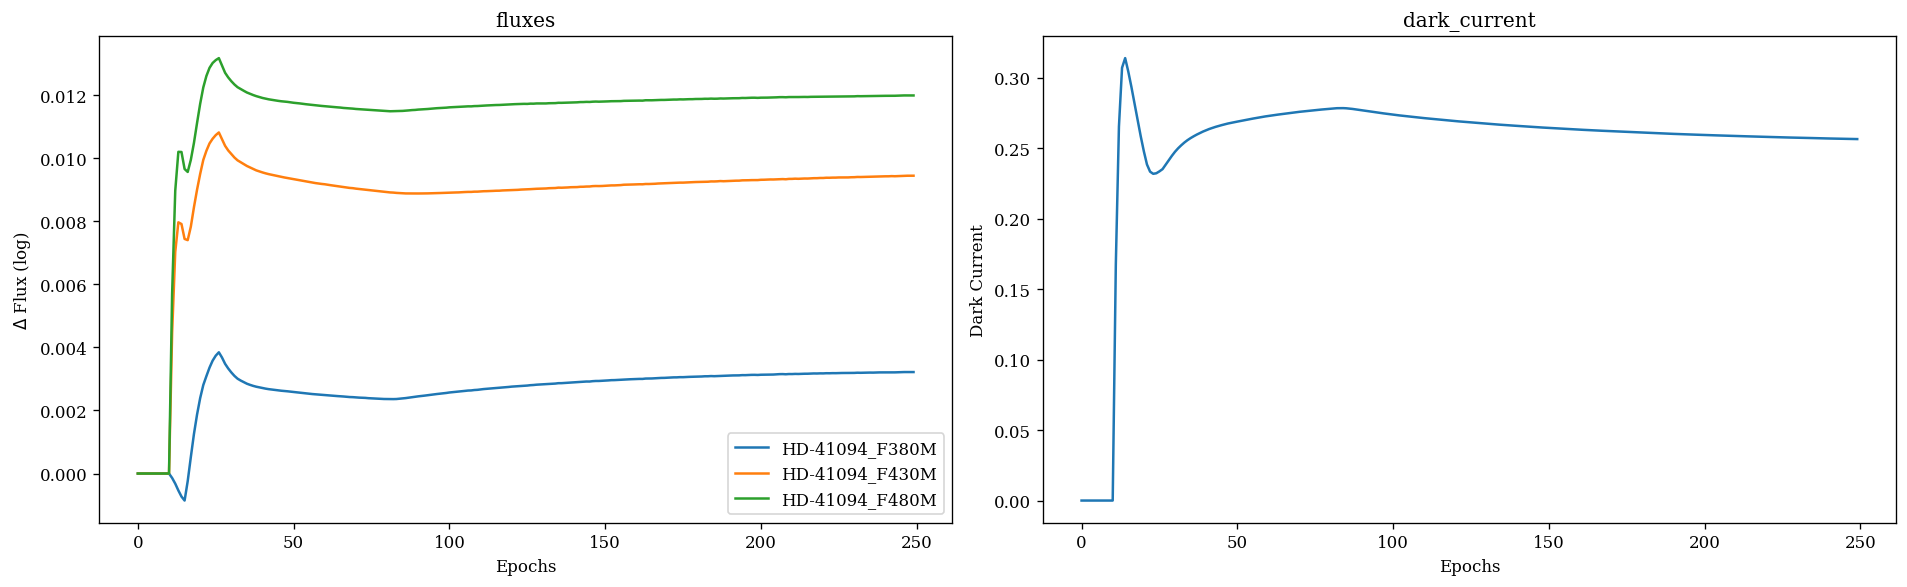

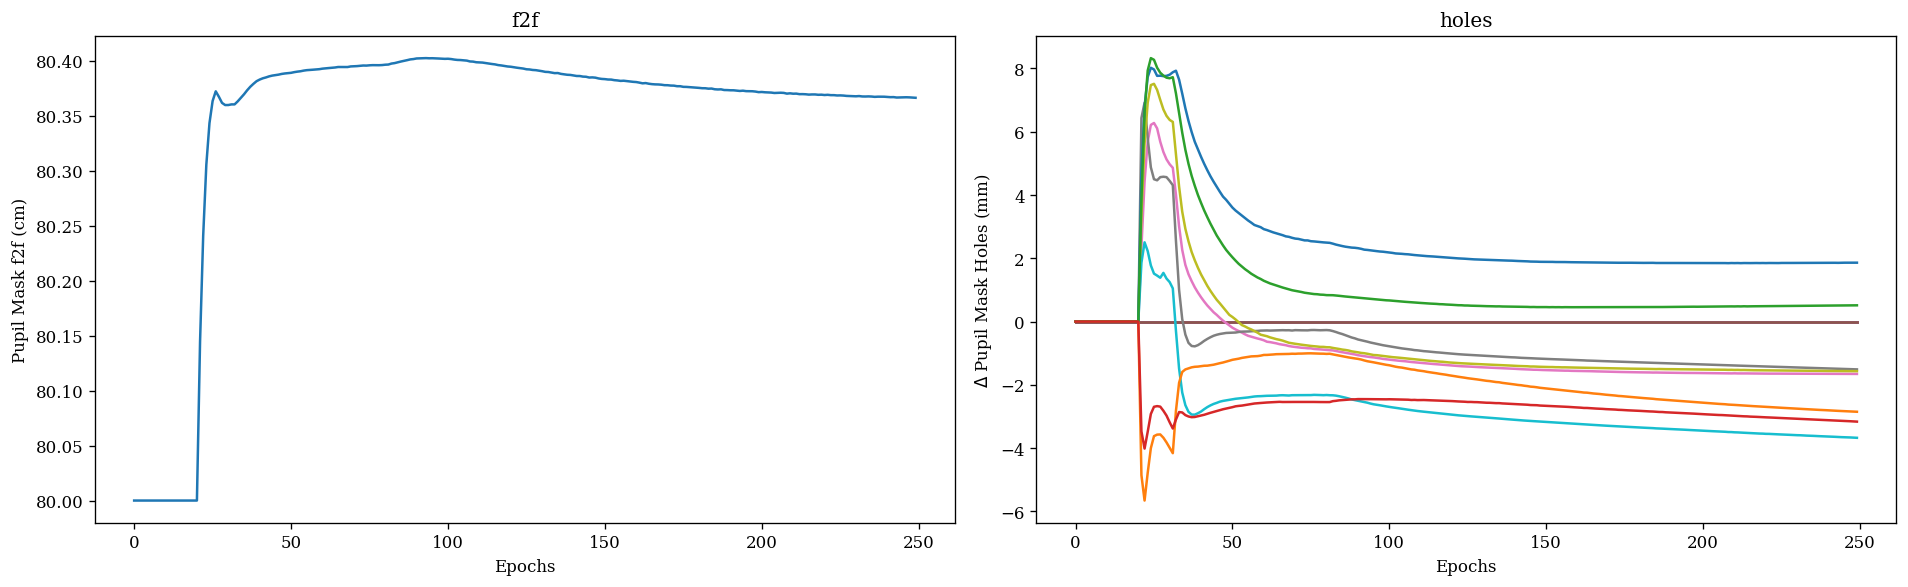

No formatting function for anisotropy.compression


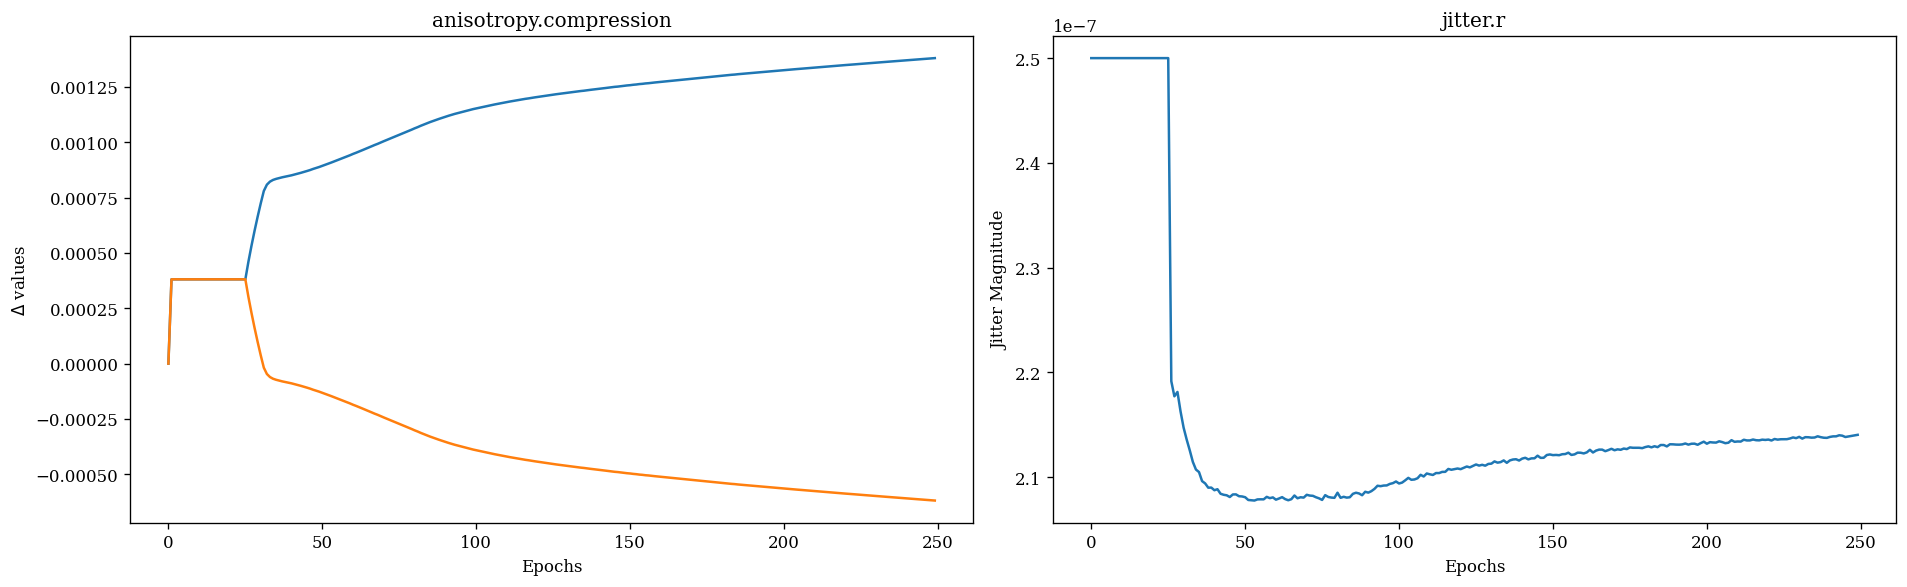

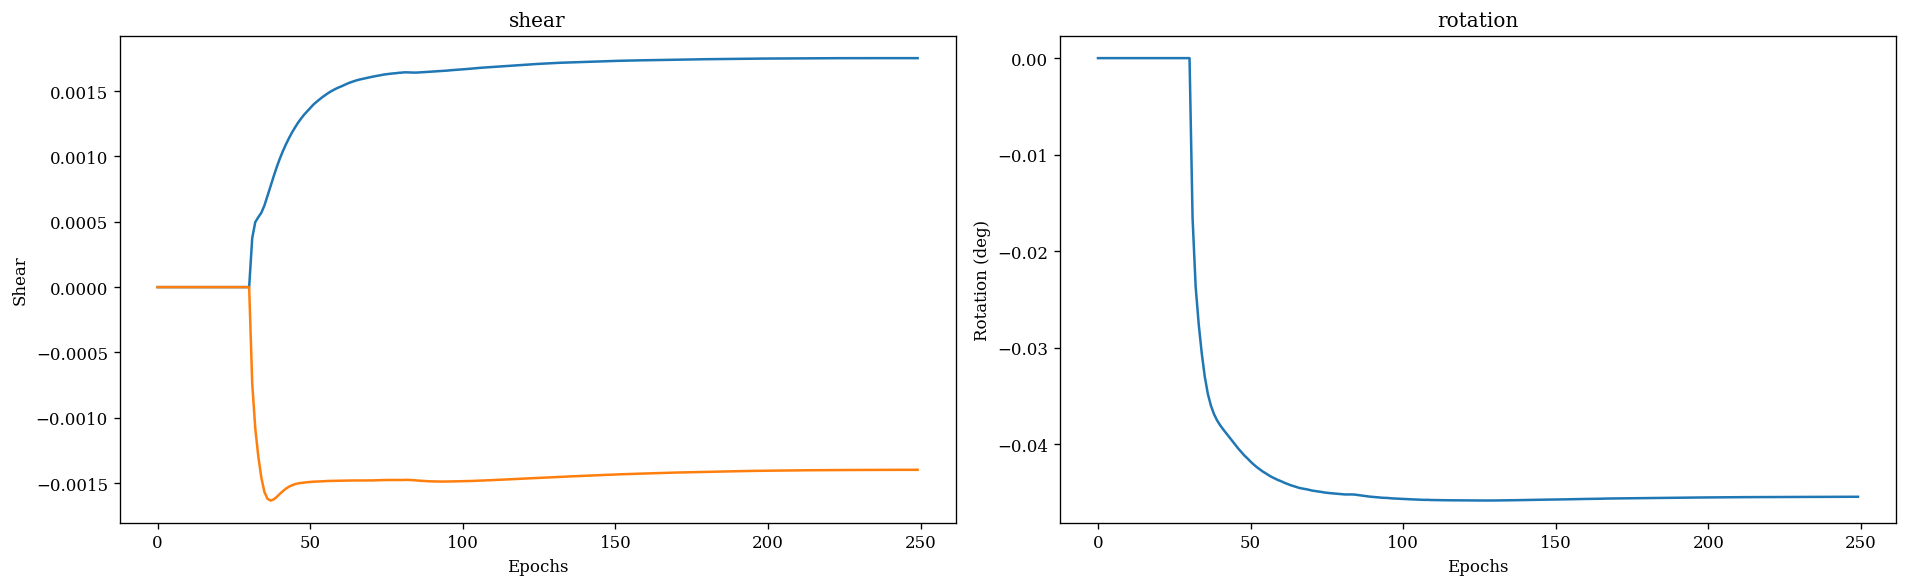

No formatting function for shifts
No formatting function for shifts
No formatting function for shifts


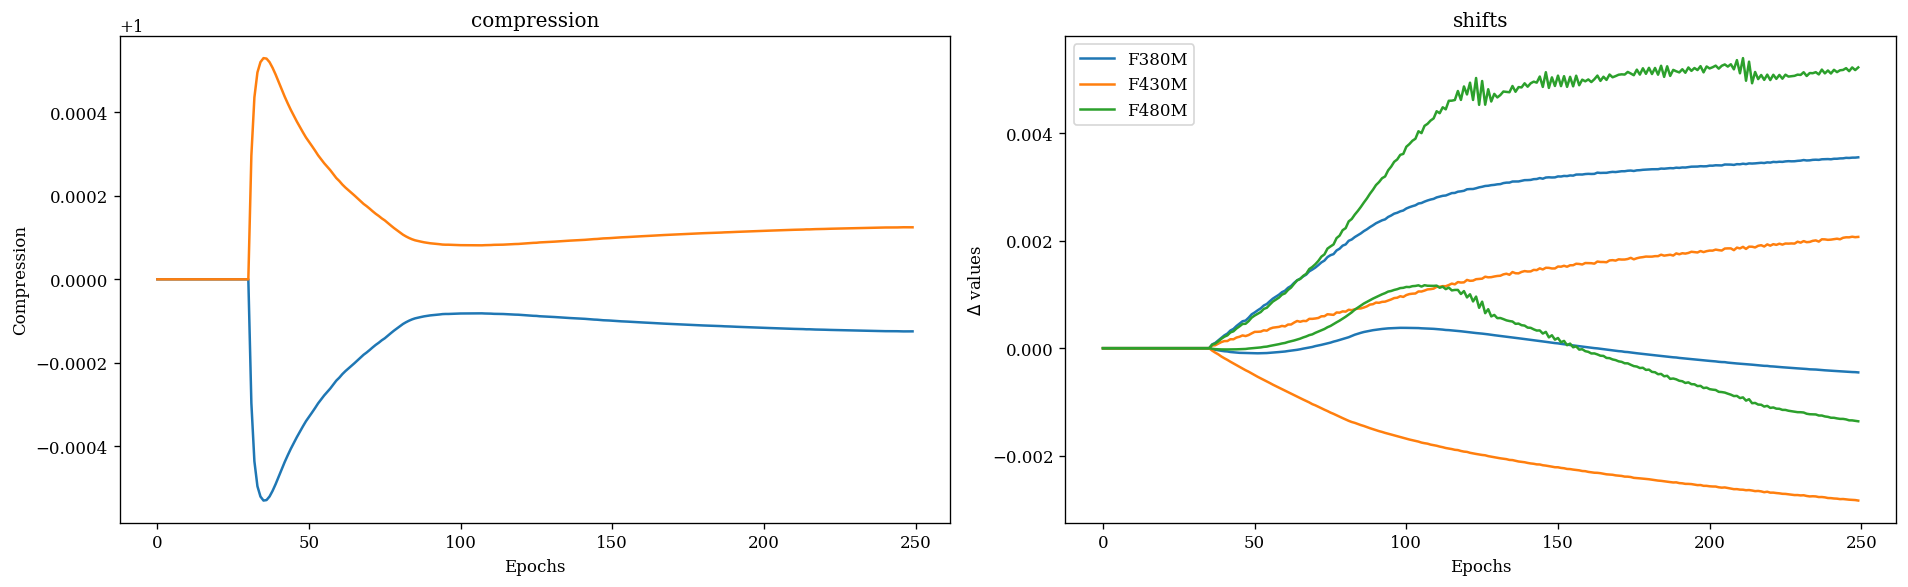

2024-07-23 09:20:32,096 - stpipe - WARNING - /Users/louis/mambaforge/envs/amigo/lib/python3.11/site-packages/amigo/plotting.py:290: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
2024-07-23 09:20:32,096 - stpipe - WARNING -   plt.tight_layout()
2024-07-23 09:20:32,097 - stpipe - WARNING - 
2024-07-23 09:20:33,539 - stpipe - WARNING - /Users/louis/mambaforge/envs/amigo/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
2024-07-23 09:20:33,539 - stpipe - WARNING -   fig.canvas.print_figure(bytes_io, **kw)
2024-07-23 09:20:33,540 - stpipe - WARNING - 


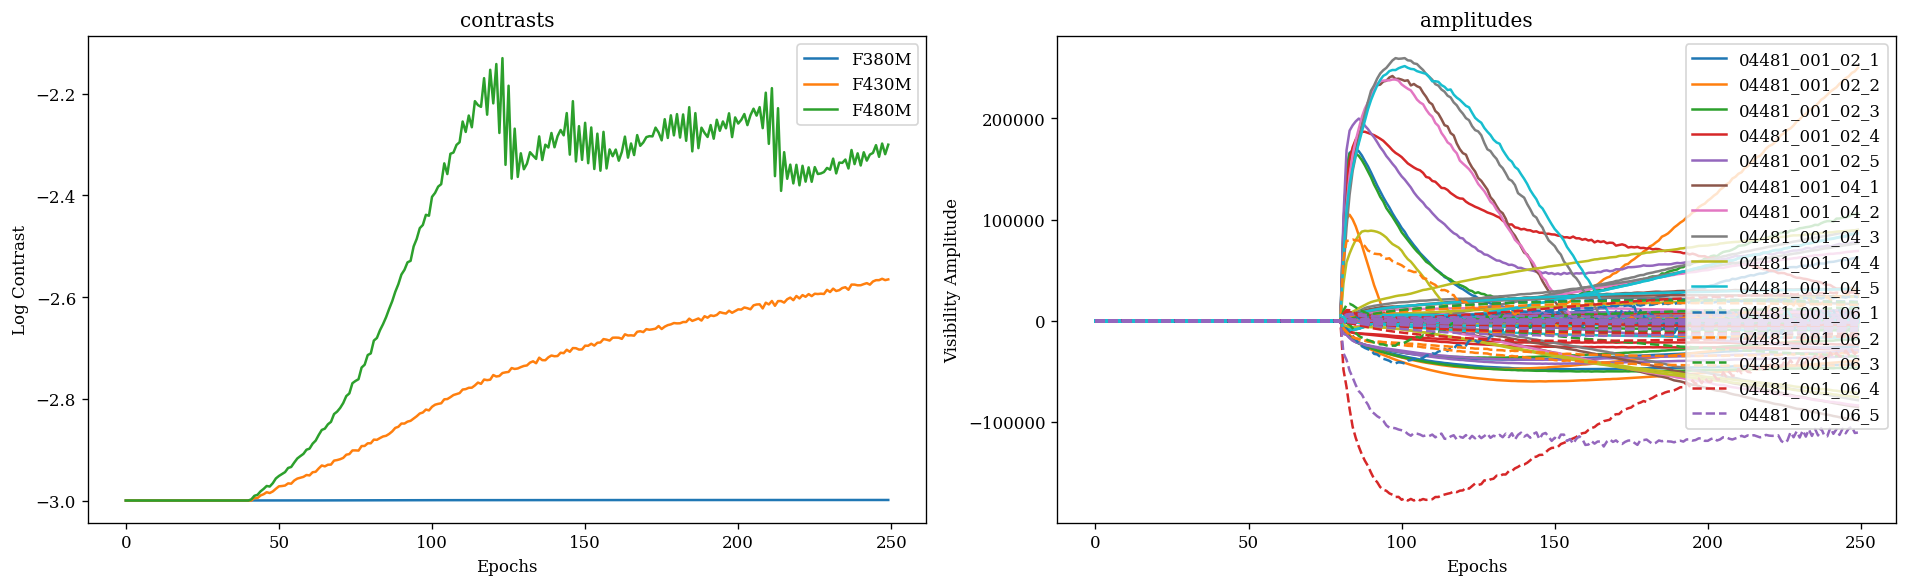

2024-07-23 09:20:54,377 - stpipe - WARNING - /Users/louis/mambaforge/envs/amigo/lib/python3.11/site-packages/amigo/plotting.py:282: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
2024-07-23 09:20:54,377 - stpipe - WARNING -   plt.tight_layout()
2024-07-23 09:20:54,378 - stpipe - WARNING - 


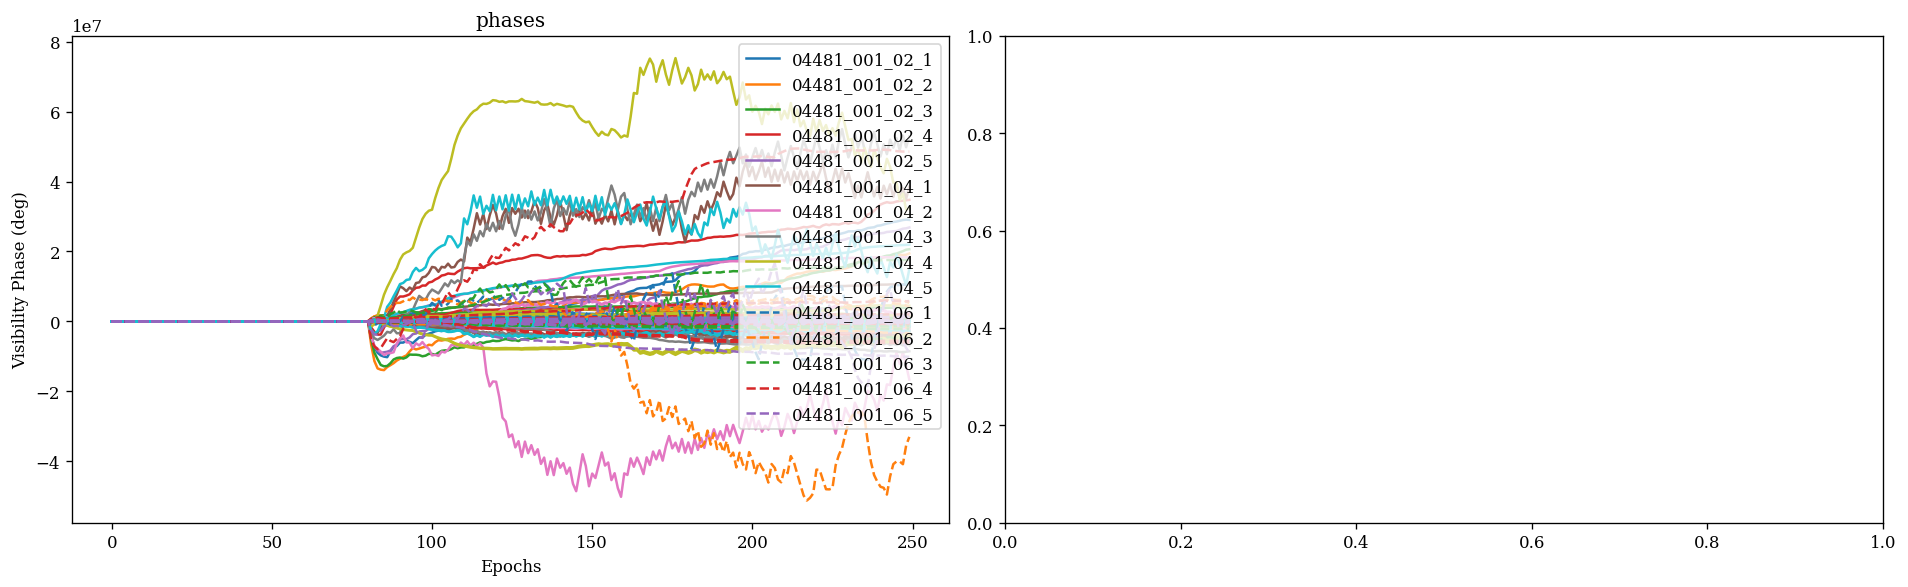

No formatting function for ramp.coeffs.2


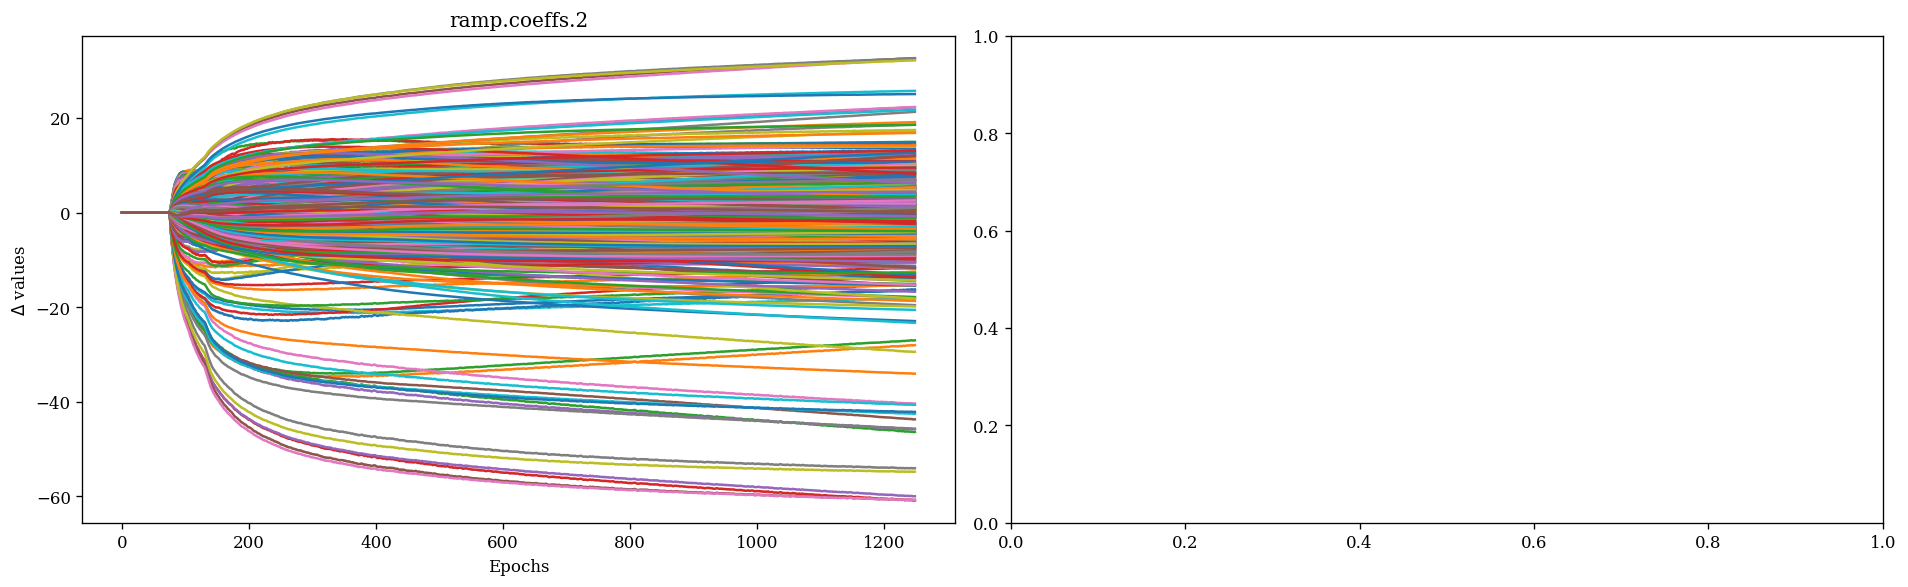

In [11]:
from amigo.plotting import plot, plot_losses

print(losses[-1].mean(), losses[-1])
end = -1

plot_losses(losses, start=15, stop=end)

for history in histories:
    plot(history, end=end)

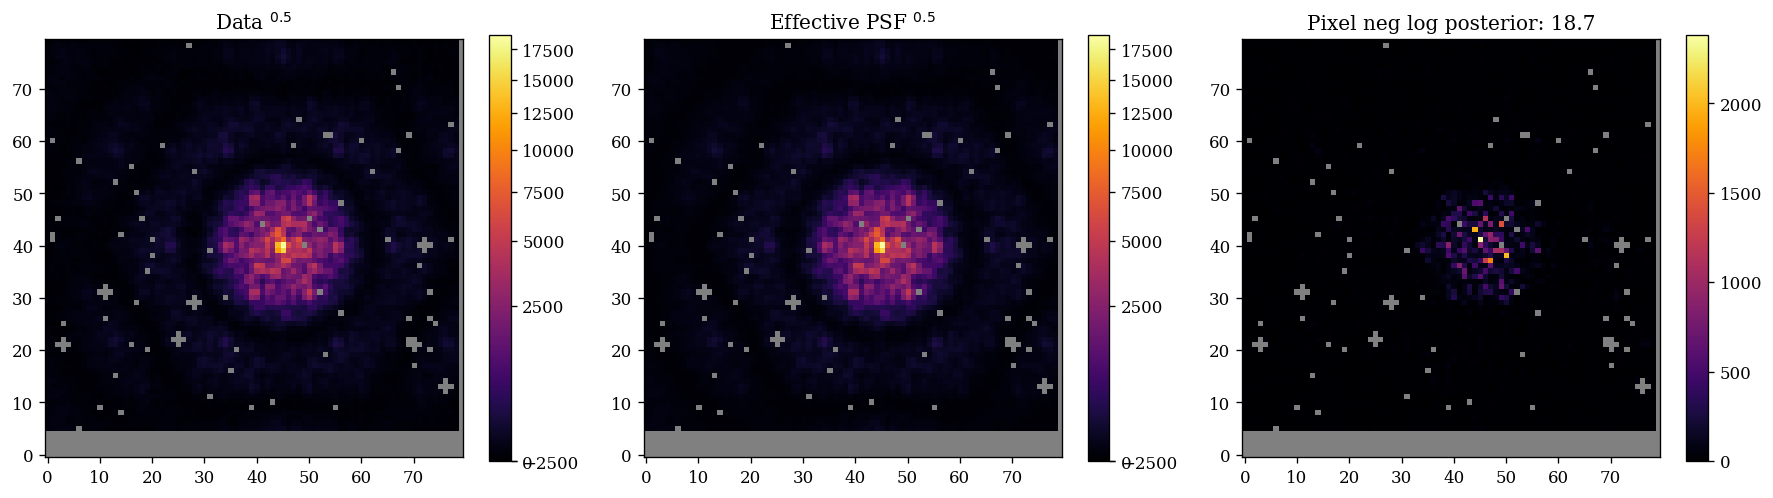

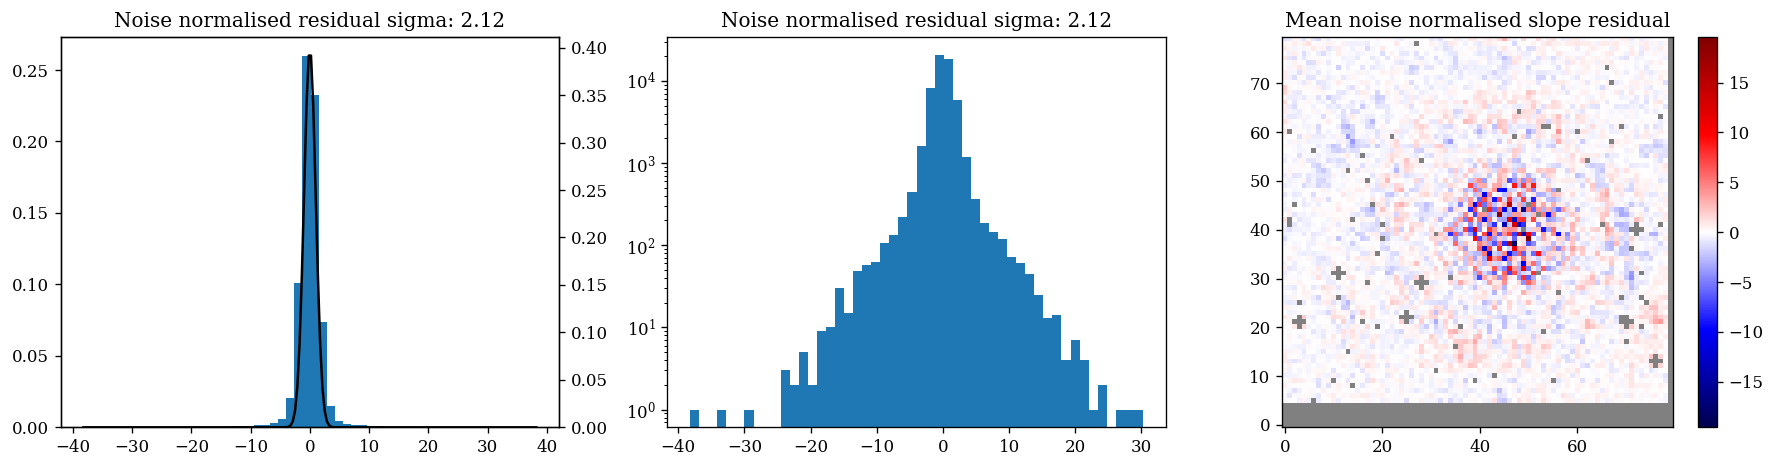

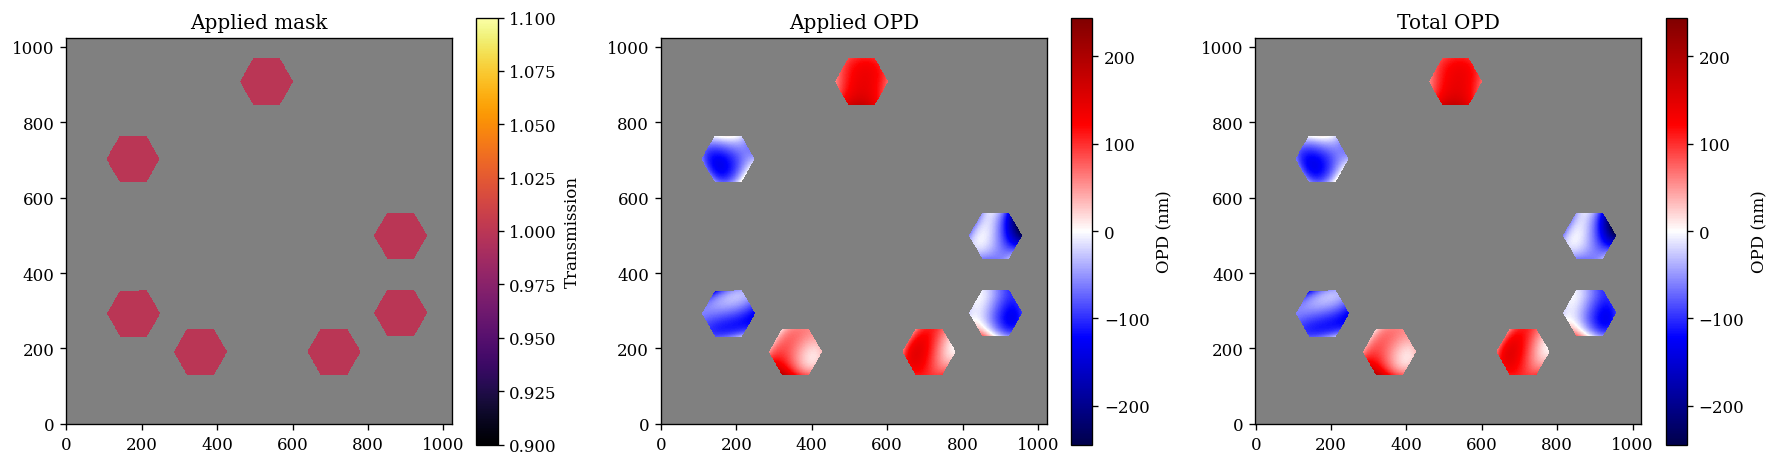

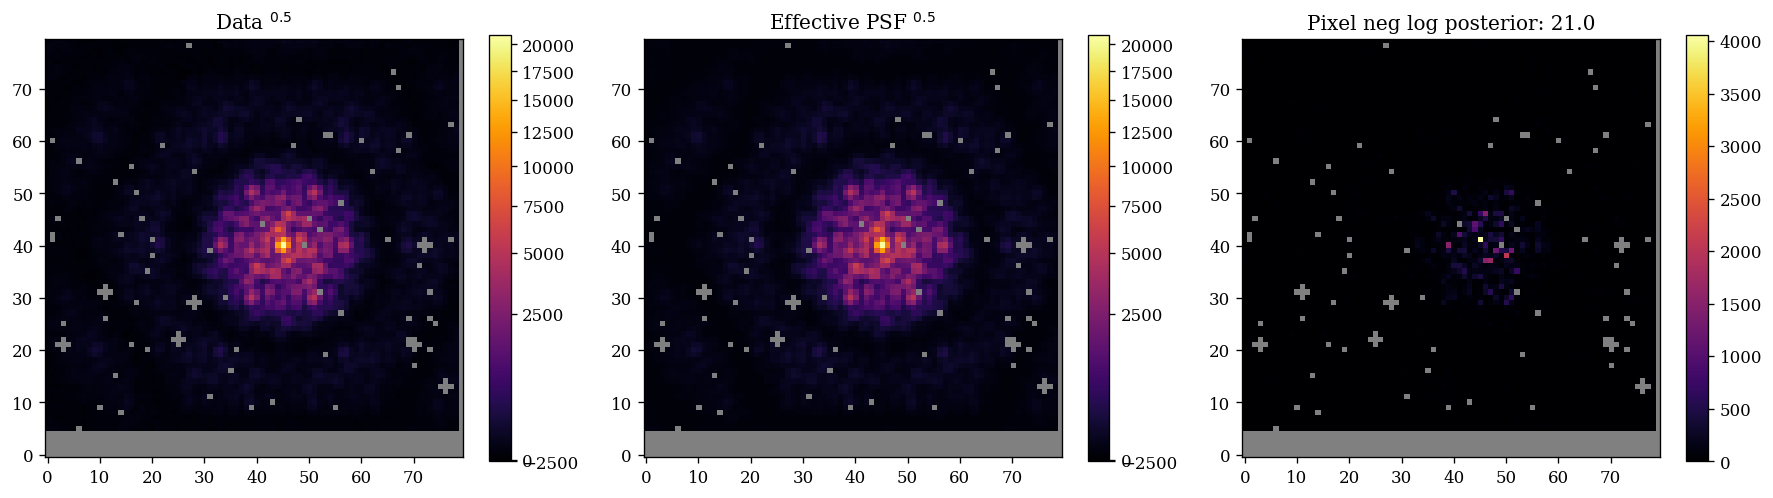

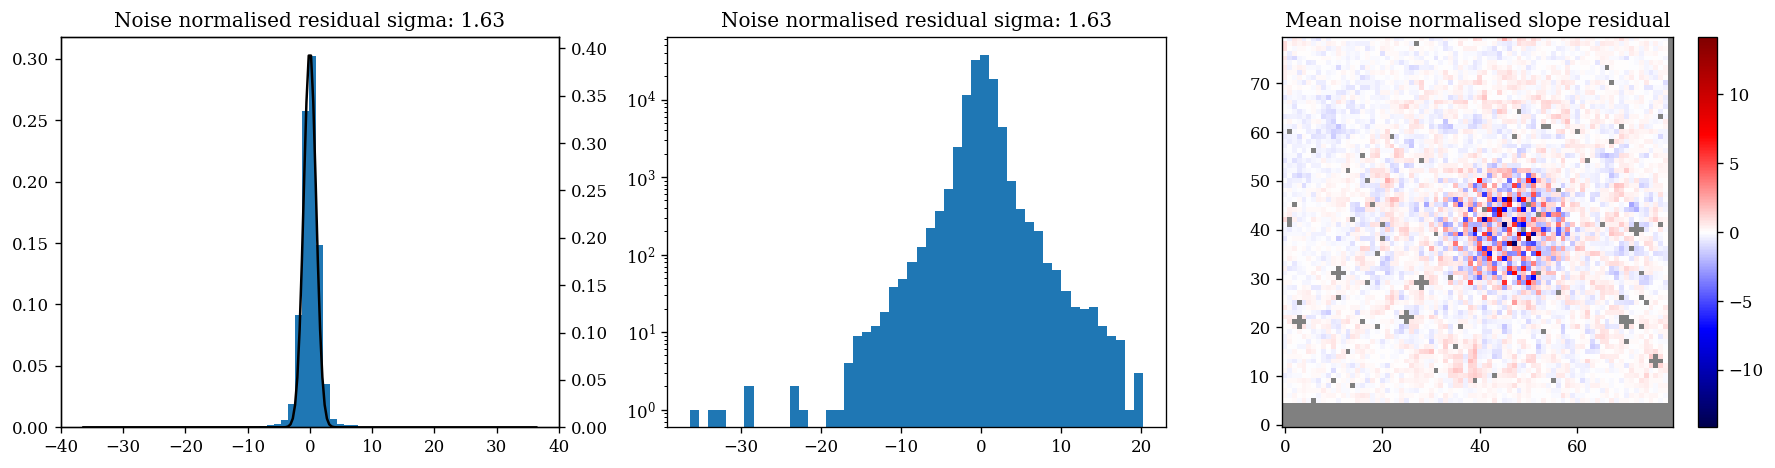

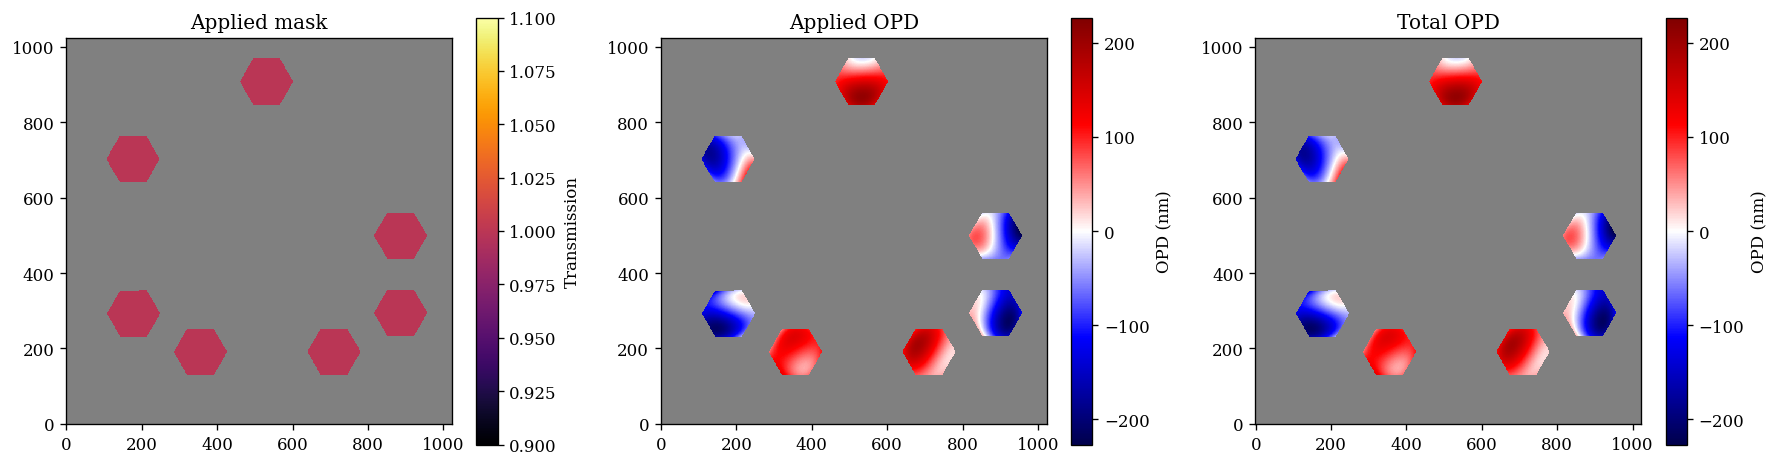

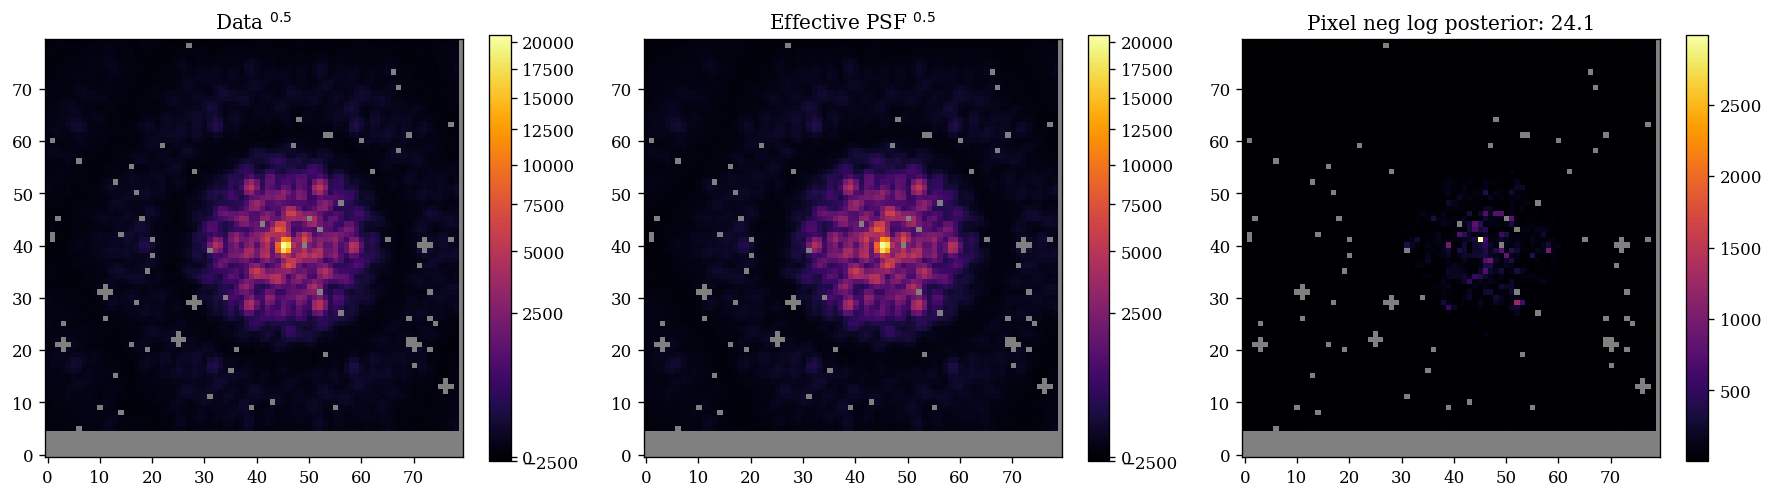

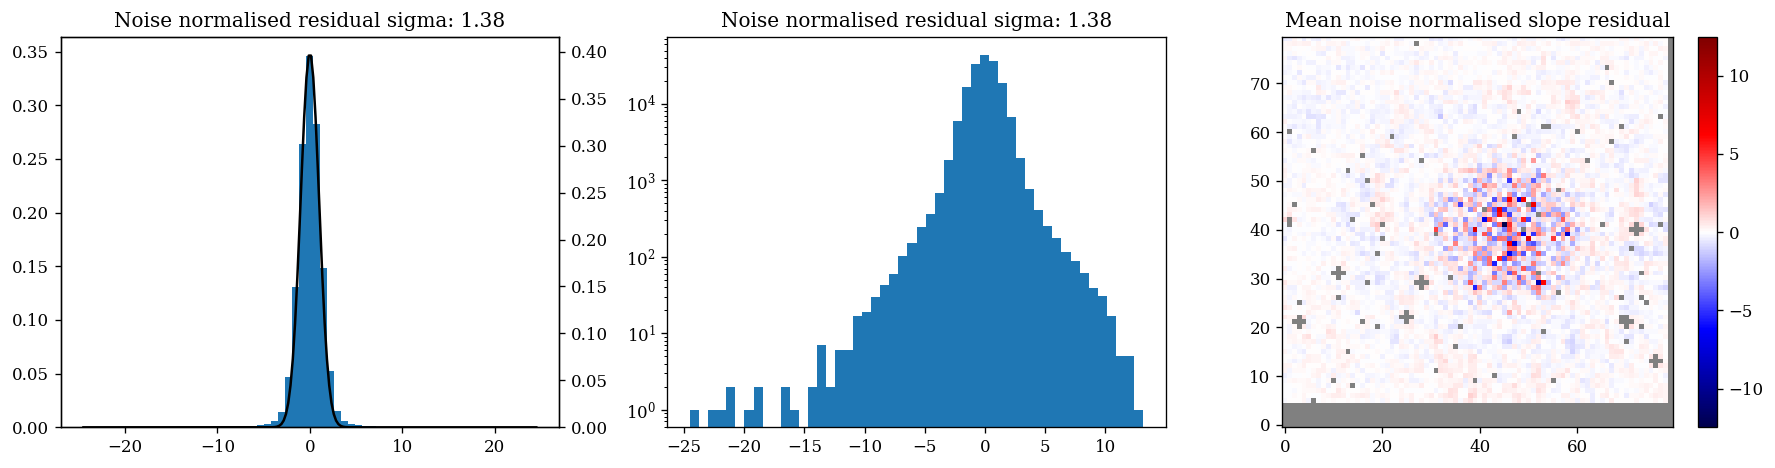

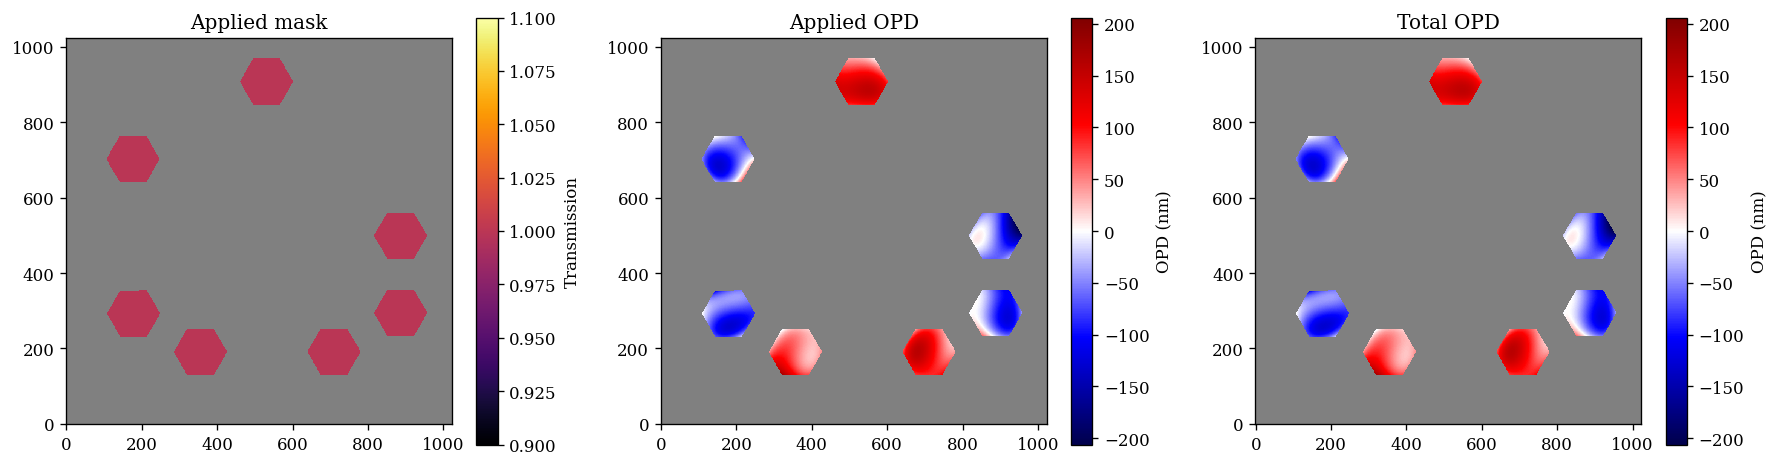

In [392]:
from amigo.plotting import summarise_fit

filts = []
for exp in exposures[1:]:
    if exp.filter in filts:
        continue
    summarise_fit(
        exp,
        final_model,
        residuals=True,
        histograms=True,
        aberrations=True,
    )
    filts.append(exp.filter)

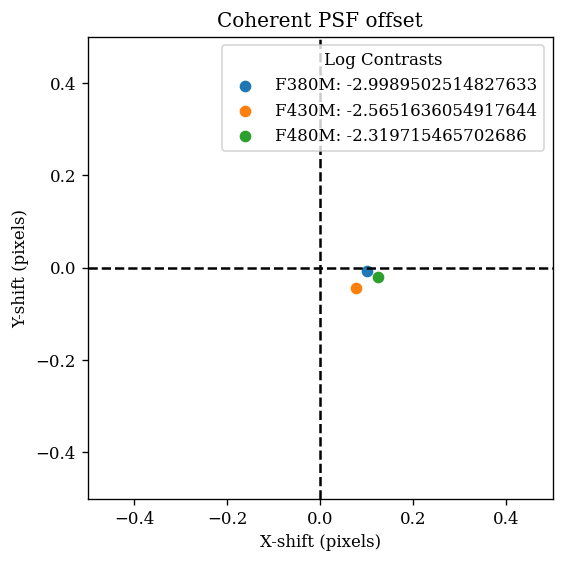

In [13]:
import jax.tree_util as jtu

shifts = jtu.tree_map(lambda x: x / optics.psf_pixel_scale, final_model.shifts)

plt.figure(figsize=(5, 5))
for filt, pos in shifts.items():
    plt.scatter(pos[0], pos[1], label=f"{filt}: {final_model.contrasts[filt]}")
plt.legend(title="Log Contrasts")

plt.title("Coherent PSF offset")
plt.xlabel("X-shift (pixels)")
plt.ylabel("Y-shift (pixels)")
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.axhline(0, color="k", linestyle="--")
plt.axvline(0, color="k", linestyle="--")

File 04481_001_04_3
Star HD-41094
Filter F380M
nints 1060
ngroups 11



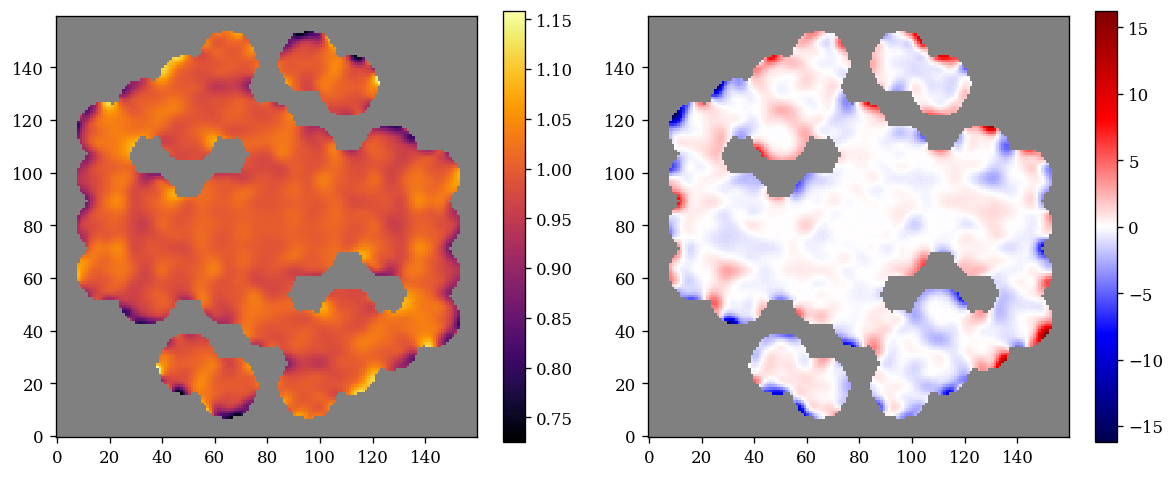

File 04481_001_06_1
Star HD-41094
Filter F430M
nints 905
ngroups 20



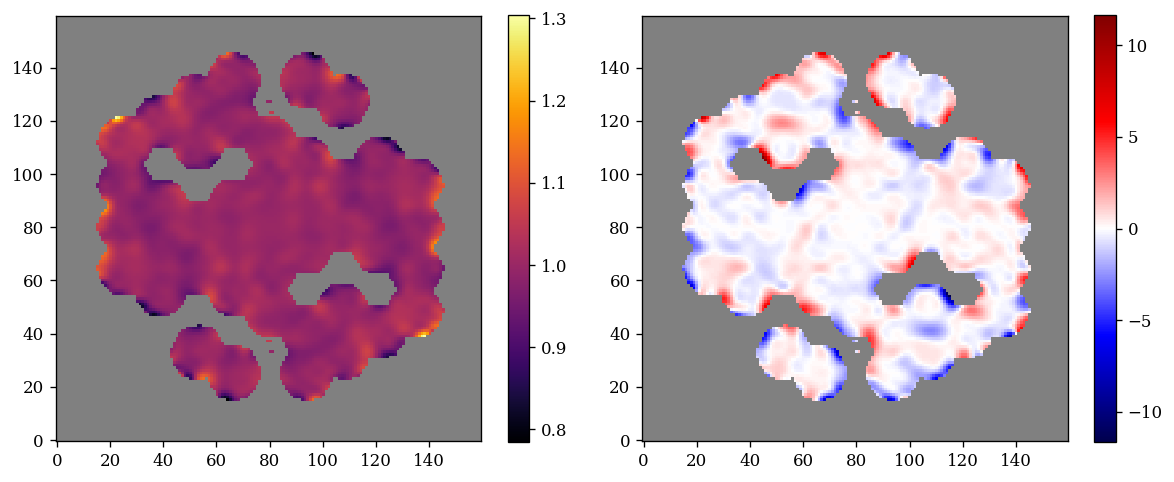

File 04481_001_02_5
Star HD-41094
Filter F480M
nints 760
ngroups 30



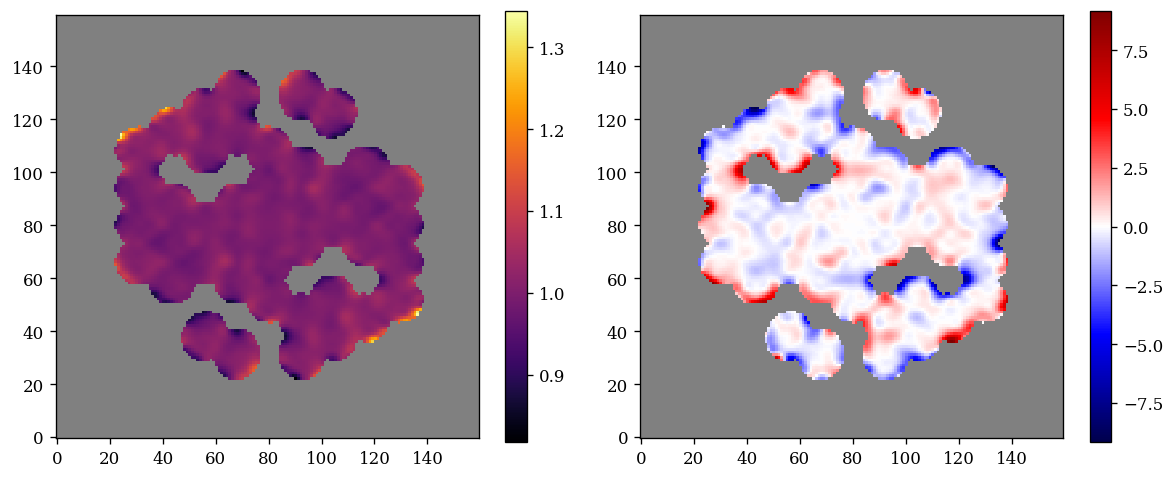

In [390]:
import dLux.utils as dlu
from amigo.interferometry import to_uv

filts = []
for exp in exposures:

    if exp.filter in filts:
        continue
    exp.print_summary()

    psf = fit.model_wfs(model, exp).psf.sum(0)
    padded = dlu.resize(psf, exp.fit.uv_pad * len(psf))
    splodges = np.abs(dlu.resize(to_uv(padded), exp.fit.crop_size))
    mask = splodges > 1e-3

    vis_map = np.where(mask, exp.fit.get_vis_map(final_model, exp), np.nan)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.abs(vis_map), inferno)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    phases = dlu.rad2deg(np.angle(vis_map))
    v = np.nanmax(np.abs(phases))
    plt.imshow(phases, seismic)
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    filts.append(exp.filter)

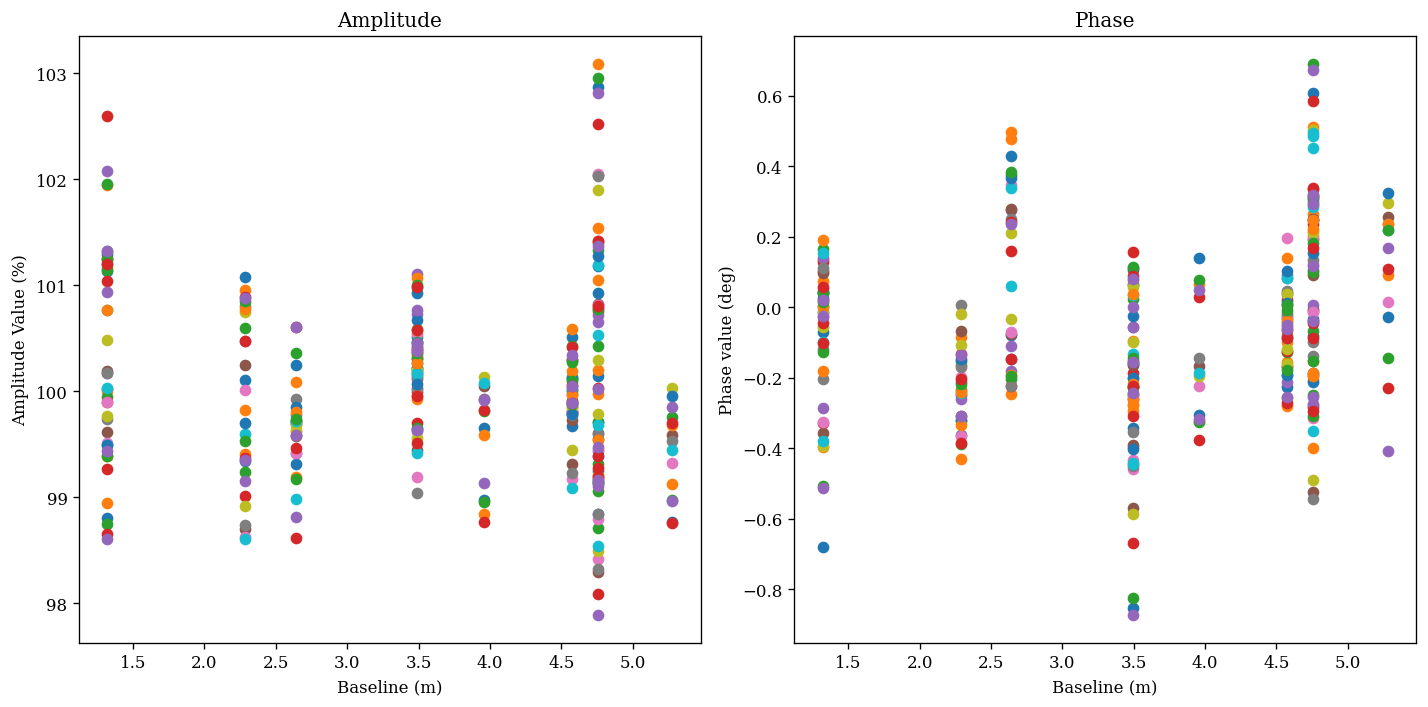

In [365]:
rs = np.hypot(*vis_model.bls.T)
bls_inds = vis_model.bls_inds

def get_vis(model, exposure):
    amplitudes = model.get(exposure.map_param("amplitudes"))
    phases = model.get(exposure.map_param("phases"))
    return build_vis_pts(amplitudes, phases, vis_model.knots[0].shape)

amplitude_vals = [np.abs(get_vis(final_model, exp)) for exp in exposures]
phase_vals = [dlu.rad2deg(np.angle(get_vis(final_model, exp))) for exp in exposures]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Amplitude")
plt.xlabel("Baseline (m)")
plt.ylabel("Amplitude Value (%)")
for exp, amp in zip(exposures, amplitude_vals):
    plt.scatter(rs, 100 * amp[*bls_inds])

plt.subplot(1, 2, 2)
plt.title("Phase")
plt.xlabel("Baseline (m)")
plt.ylabel("Phase value (deg)")
for exp, phase in zip(exposures, phase_vals):
    plt.scatter(rs, phase[*bls_inds])

plt.tight_layout()
plt.show()

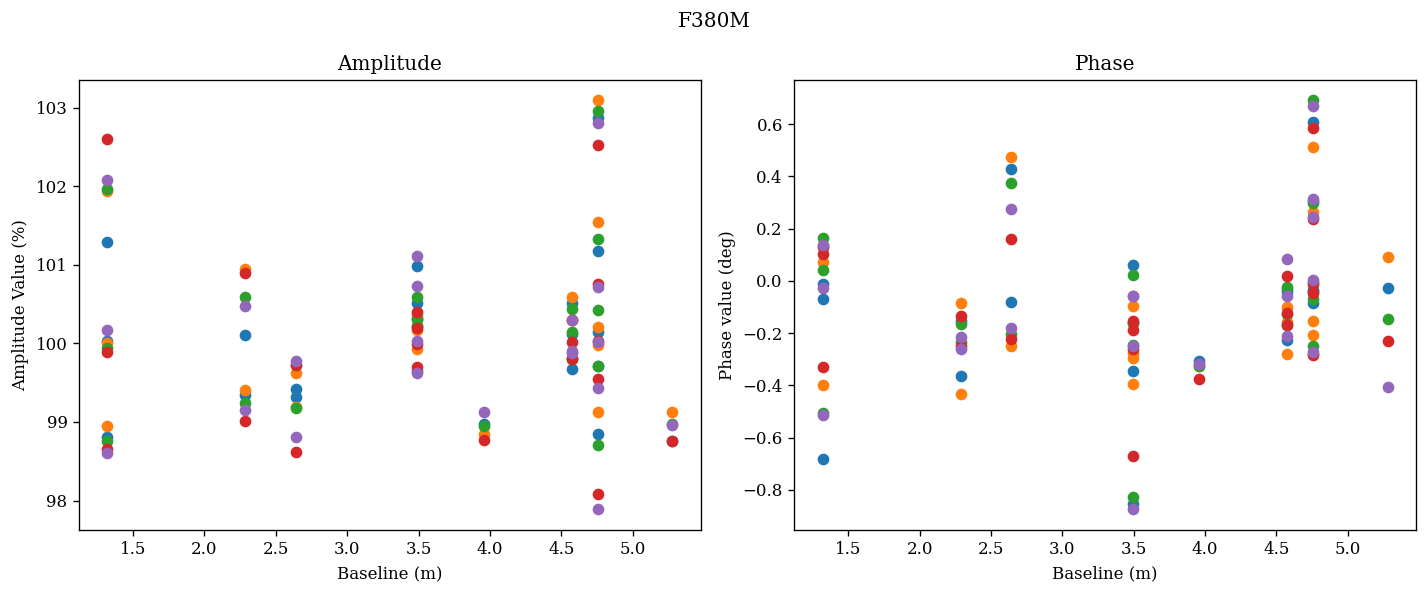

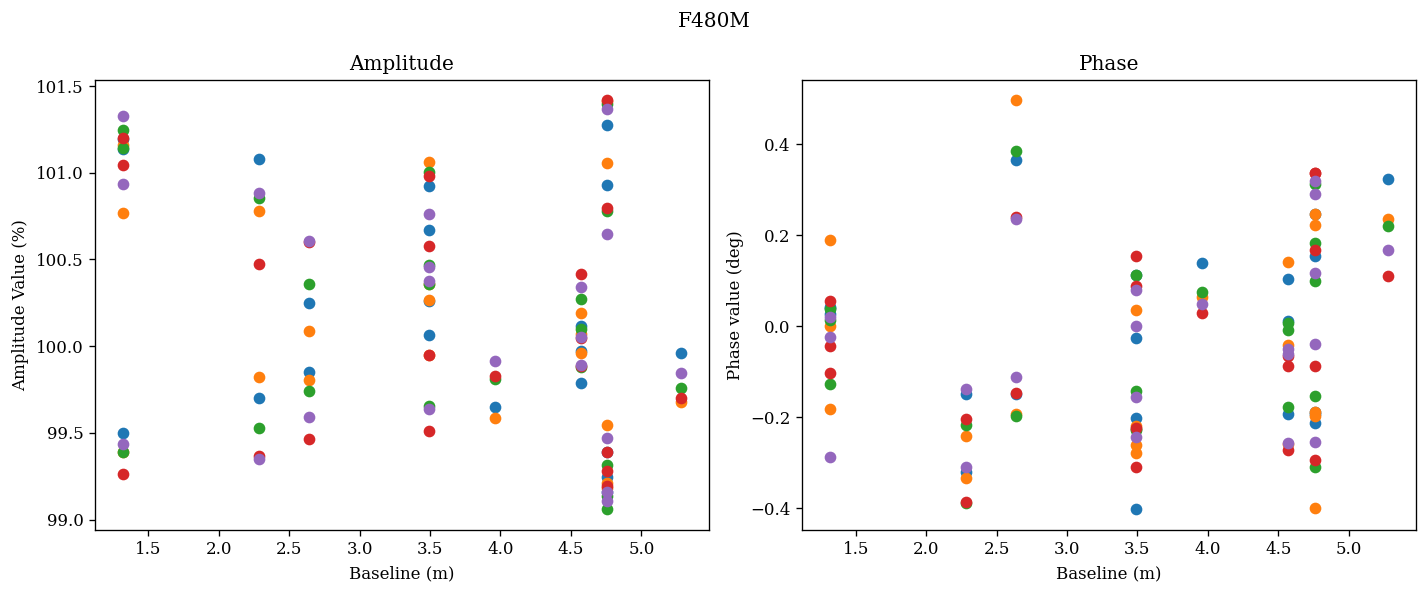

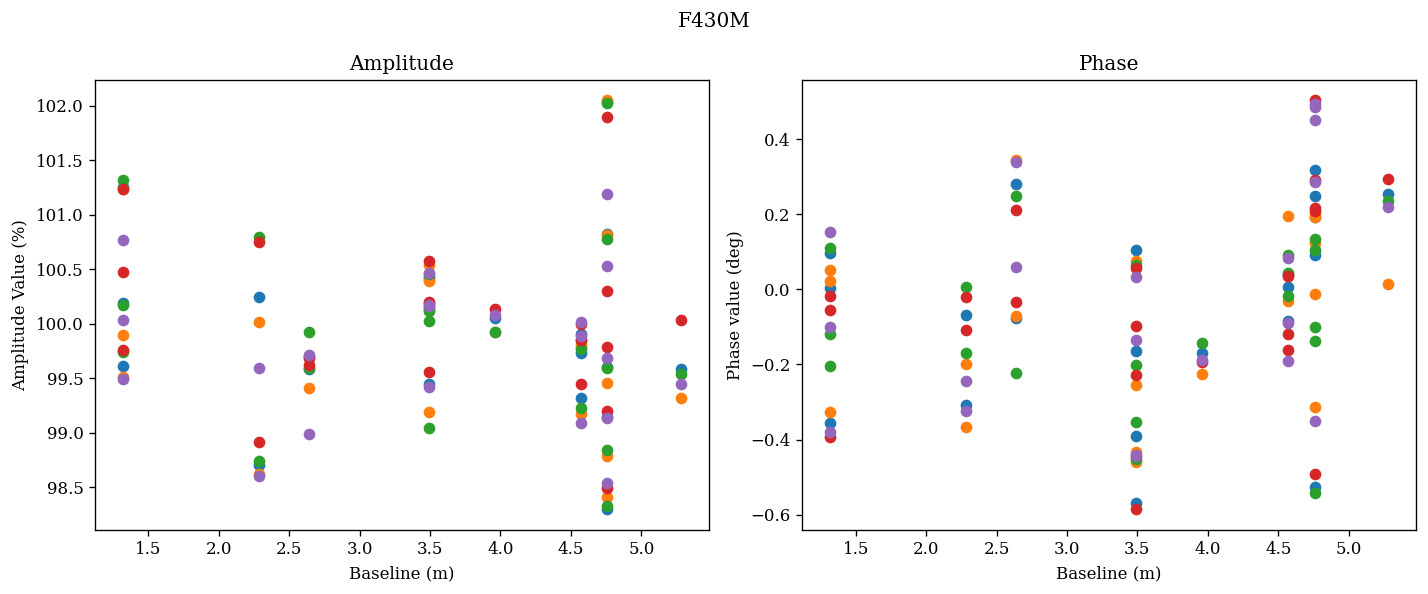

In [366]:
rs = np.hypot(*vis_model.bls.T)
bls_inds = vis_model.bls_inds

for filt in set([exp.filter for exp in exposures]):

    exps_in = [exp if exp.filter == filt else None for exp in exposures]
    skip = all([exp is None for exp in exps_in])
    if skip:
        continue

    plt.figure(figsize=(12, 5))
    plt.suptitle(filt)
    plt.subplot(1, 2, 1)
    plt.title("Amplitude")
    plt.xlabel("Baseline (m)")
    plt.ylabel("Amplitude Value (%)")
    for exp in exps_in:
        if exp is None:
            continue 

        amplitudes = np.abs(get_vis(final_model, exp))
        plt.scatter(rs, 100 * amplitudes[*bls_inds])

    plt.subplot(1, 2, 2)
    plt.title("Phase")
    plt.xlabel("Baseline (m)")
    plt.ylabel("Phase value (deg)")
    for exp in exps_in:
        if exp is None:
            continue 
        phases = dlu.rad2deg(np.angle(get_vis(final_model, exp)))
        plt.scatter(rs, phases[*bls_inds])

    plt.tight_layout()
    plt.show()

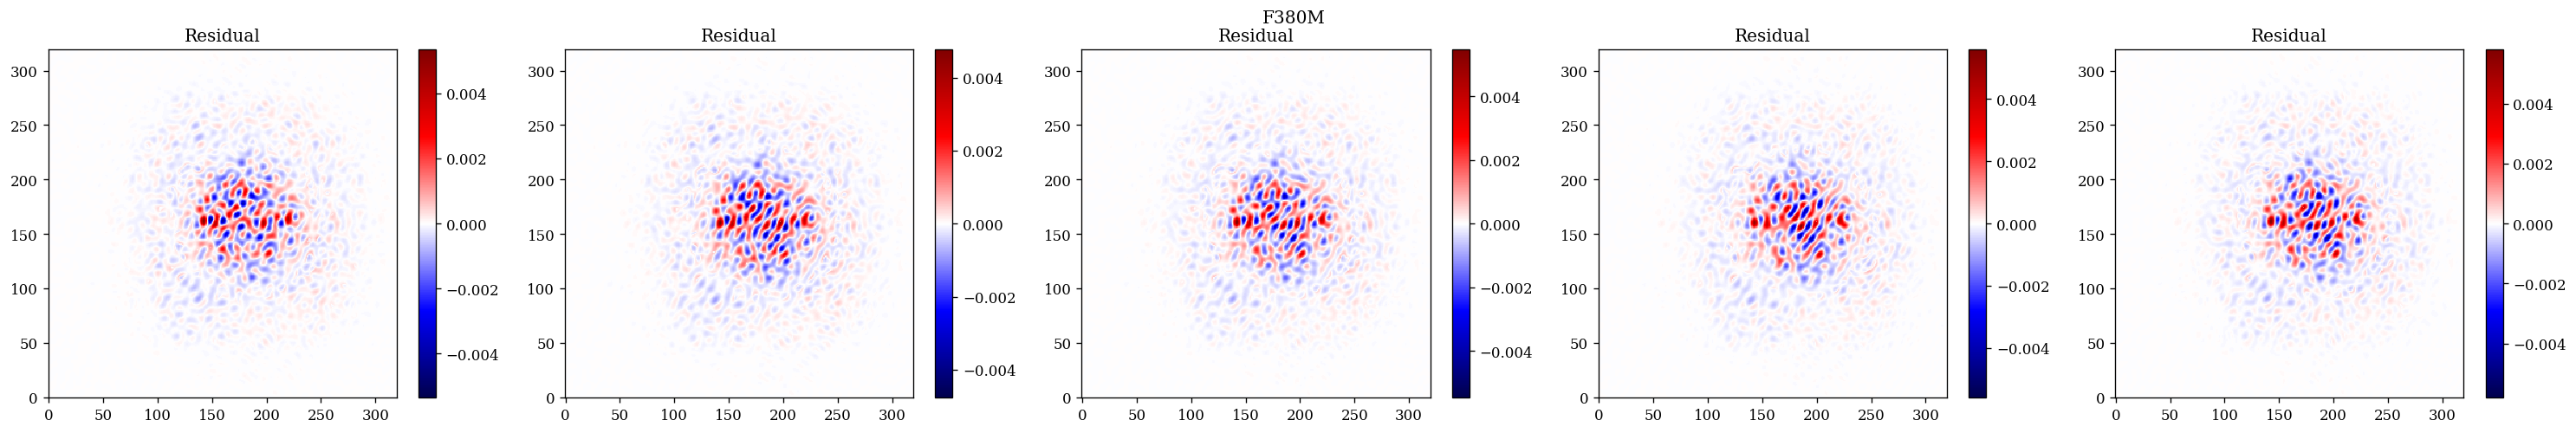

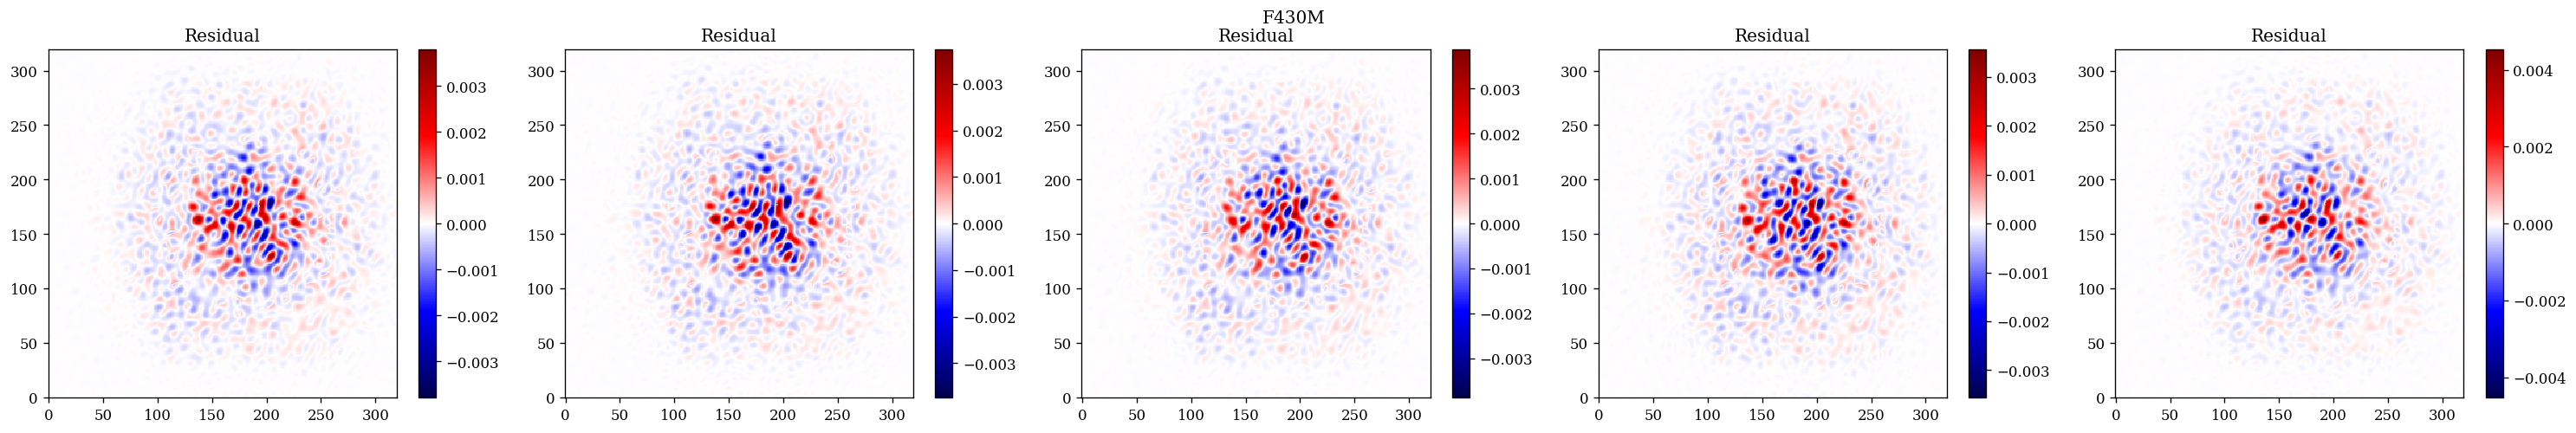

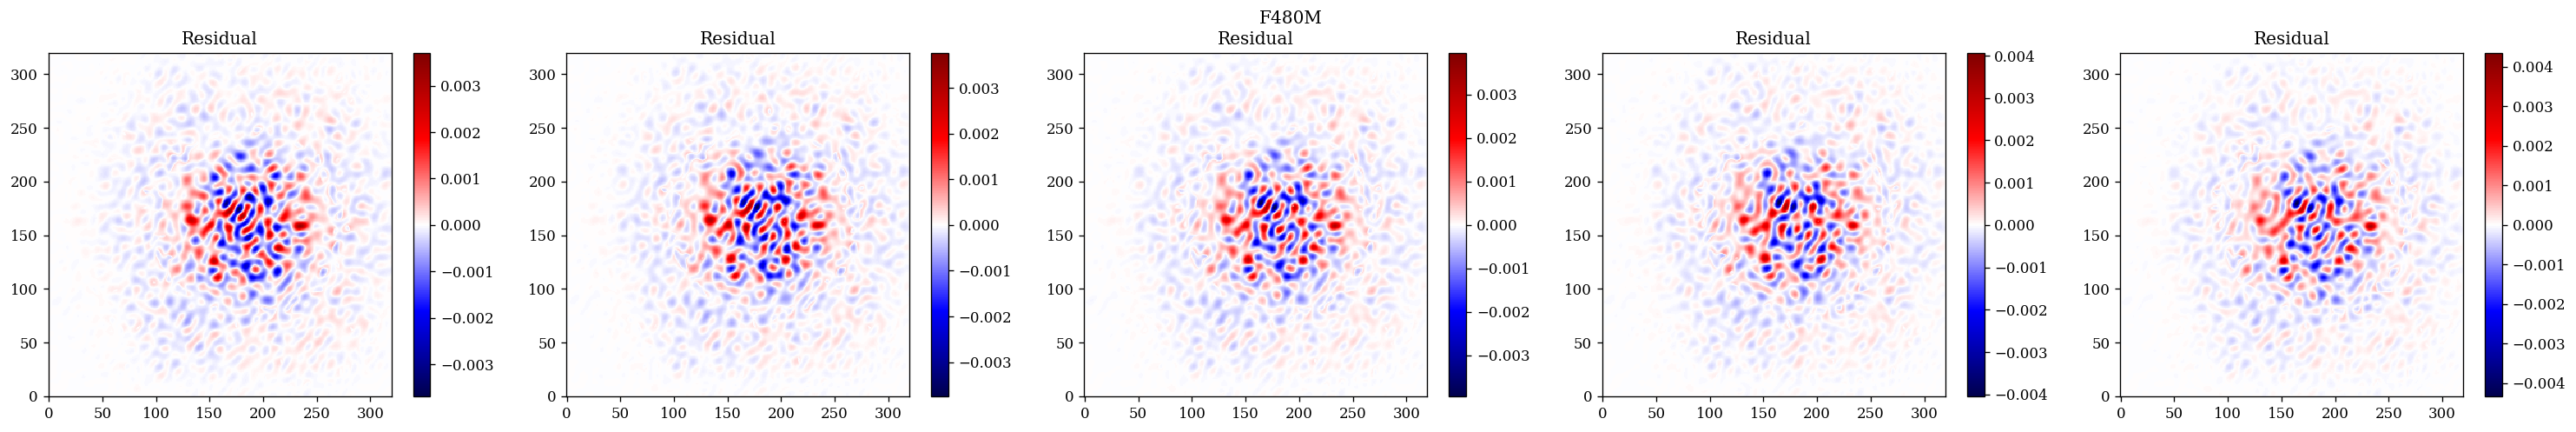

In [368]:
for filt in ["F380M", "F430M", "F480M"]:

    plt.figure(figsize=(25, 4))
    plt.suptitle(filt)
    idx = 1
    exps_in = [exp if exp.filter == filt else None for exp in exposures]
    for exp in exps_in:
        if exp is None:
            continue

        orig_psf = fit.model_psf(final_model, exp)
        new_psf = fit.model_vis(orig_psf, final_model, exp)

        orig_psf = orig_psf.data
        new_psf = new_psf.data

        norm = orig_psf.max()
        orig_psf /= norm
        new_psf /= norm

        plt.subplot(1, 5, idx)
        plt.title("Residual")
        res = orig_psf - new_psf
        v = np.abs(res).max()
        plt.imshow(res, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()

        idx += 1
    plt.tight_layout()
    plt.show()

In [374]:
def get_vis(model, exposure):
    amplitudes = model.get(exposure.map_param("amplitudes"))
    phases = model.get(exposure.map_param("phases"))
    return build_vis_pts(amplitudes, phases, vis_model.knots[0].shape)


def nearest_fn(pt, coords):
    dist = np.hypot(*(coords - pt[:, None, None]))
    return dist == dist.min()


def convert_adjacent_to_true(bool_array, corners=False):
    trues = np.array(np.where(bool_array))
    trues = np.swapaxes(trues, 0, 1)
    for i in range(len(trues)):
        y, x = trues[i]
        bool_array = bool_array.at[y, x + 1].set(True)
        bool_array = bool_array.at[y, x - 1].set(True)
        bool_array = bool_array.at[y + 1, x].set(True)
        bool_array = bool_array.at[y - 1, x].set(True)
        if corners:
            bool_array = bool_array.at[y + 1, x + 1].set(True)
            bool_array = bool_array.at[y - 1, x - 1].set(True)
            bool_array = bool_array.at[y + 1, x - 1].set(True)
            bool_array = bool_array.at[y - 1, x + 1].set(True)
    return bool_array

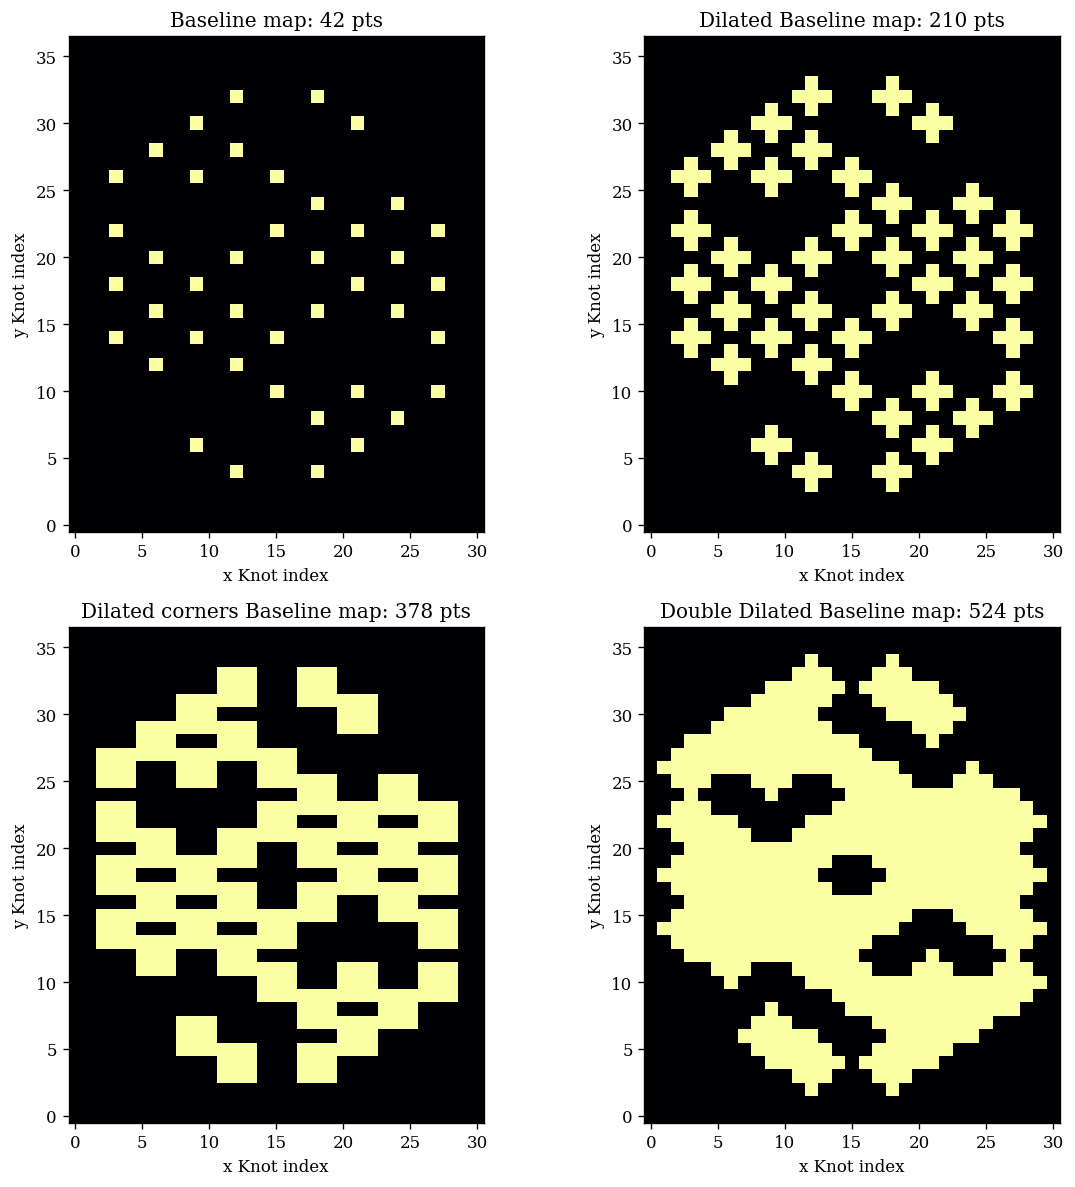

In [375]:
from jax import vmap

is_near = vmap(nearest_fn, (0, None))(vis_model.bls, vis_model.knots)
is_conj = vmap(nearest_fn, (0, None))(-vis_model.bls, vis_model.knots)

bls_map = np.sum(is_near.astype(int), 0) + np.sum(is_conj.astype(int), 0)
dilated_bls_map = convert_adjacent_to_true(bls_map.astype(bool))
double_dilated_bls_map = convert_adjacent_to_true(dilated_bls_map)
corner_bls_map = convert_adjacent_to_true(bls_map.astype(bool), corners=True)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title(f"Baseline map: {bls_map.sum()} pts")
plt.xlabel("x Knot index")
plt.ylabel("y Knot index")
plt.imshow(bls_map)

plt.subplot(2, 2, 2)
plt.title(f"Dilated Baseline map: {dilated_bls_map.sum()} pts")
plt.xlabel("x Knot index")
plt.ylabel("y Knot index")
plt.imshow(dilated_bls_map)

plt.subplot(2, 2, 3)
plt.title(f"Dilated corners Baseline map: {corner_bls_map.sum()} pts")
plt.xlabel("x Knot index")
plt.ylabel("y Knot index")
plt.imshow(corner_bls_map)

plt.subplot(2, 2, 4)
plt.title(f"Double Dilated Baseline map: {double_dilated_bls_map.sum()} pts")
plt.xlabel("x Knot index")
plt.ylabel("y Knot index")
plt.imshow(double_dilated_bls_map)

plt.tight_layout()
plt.show()

flat_bls_inds = np.array(np.where(bls_map.flatten()))[:, :bls_map.sum()//2]
flat_bls_inds_dilate = np.array(np.where(dilated_bls_map.flatten()))[:, :dilated_bls_map.sum()//2]
flat_bls_inds_double_dilate = np.array(np.where(double_dilated_bls_map.flatten()))[:, :double_dilated_bls_map.sum()//2]
flat_bls_inds_corner = np.array(np.where(corner_bls_map.flatten()))[:, :corner_bls_map.sum()//2]

In [381]:
import time
from amigo.stats import posterior
from amigo.fisher import hessian
from tqdm.notebook import tqdm

inds_in = flat_bls_inds
N = len(inds_in[0])
X = np.zeros(N)

amp_fishers = {}
pha_fishers = {}
for exp in tqdm(exposures):

    # Build function to calculate FIM and calculate
    def amp_loglike(X):
        amplitudes = final_model.amplitudes[exp.key].at[*inds_in].add(X)
        pytree = final_model.set(f"amplitudes.{exp.key}", amplitudes)
        return posterior(pytree, exp, per_pix=False)

    def pha_loglike(X):
        phases = final_model.phases[exp.key].at[*inds_in].add(X)
        pytree = final_model.set(f"phases.{exp.key}", phases)
        return posterior(pytree, exp, per_pix=False)

    amp_fishers[exp.key] = hessian(amp_loglike, X)
    pha_fishers[exp.key] = hessian(pha_loglike, X)


  0%|          | 0/15 [00:00<?, ?it/s]

In [382]:
amp_errs = jtu.tree_map(lambda x: np.diag(-np.linalg.inv(x)) ** 0.5, amp_fishers)
pha_errs = jtu.tree_map(lambda x: np.diag(-np.linalg.inv(x)) ** 0.5, pha_fishers)
vis_err = jtu.tree_map(lambda amp, pha: amp * np.exp(1j * pha), amp_errs, pha_errs)

In [383]:
import jax.tree_util as jtu

import numpy as onp
from uncertainties import ufloat


def vis2ufloat(vis, err):
    amp = onp.array([ufloat(np.abs(a), np.abs(e)) for a, e in zip(vis, err)])
    pha = onp.array([ufloat(np.abs(a), np.abs(e)) for a, e in zip(vis, err)])
    return amp, pha

def ufloat2jax(arr):
    vals = np.array([v.nominal_value for v in arr])
    errs = np.array([v.std_dev for v in arr])
    return vals, errs


def add_vis_errs(vis_list, vis_err_list):
    amps = [vis2ufloat(vis, err)[0] for vis, err in zip(vis_list, vis_err_list)]
    phas = [vis2ufloat(vis, err)[1] for vis, err in zip(vis_list, vis_err_list)]

    amp, amp_err = ufloat2jax(onp.array(amps).mean(0))
    pha, pha_err = ufloat2jax(onp.array(phas).mean(0))

    mean_vis = amp * np.exp(1j * pha)
    mean_vis_err = amp_err * np.exp(1j * pha_err)
    return mean_vis, mean_vis_err


def calibrate_vis(sci_vis, sci_vis_err, cal_vis, cal_vis_err):
    sci_amp, sci_pha = vis2ufloat(sci_vis, sci_vis_err)
    cal_amp, cal_pha = vis2ufloat(cal_vis, cal_vis_err)

    calib_amp, calib_amp_err = ufloat2jax(sci_amp / cal_amp)
    calib_pha, calib_pha_err = ufloat2jax(sci_pha - cal_pha)

    calib_vis = calib_amp * np.exp(1j * calib_pha)
    calib_vis_err = calib_amp_err * np.exp(1j * calib_pha_err)
    return calib_vis, calib_vis_err

In [384]:
# Divide into filters
exp_filters = {}
for exp in exposures:
    if exp.filter not in exp_filters.keys():
        exp_filters[exp.filter] = [exp]
    else:
        exp_filters[exp.filter].append(exp)

In [386]:
# Calibrate
calibrated_vis = {
    "F380M": {},
    "F430M": {},
    "F480M": {},
}

calibrated_vis_err = {
    "F380M": {},
    "F430M": {},
    "F480M": {},
}

for filt, exps_in in exp_filters.items():
    for i, sci_exp in enumerate(exps_in):
        vis_in, err_in = [], []
        for j, cal_exp in enumerate(exps_in):
            if i == j:
                continue
            vis_in.append(get_vis(final_model, cal_exp)[*vis_model.bls_inds])
            err_in.append(vis_err[cal_exp.key])
        cal_vis, cal_vis_err = add_vis_errs(vis_in, err_in)

        sci_vis = get_vis(final_model, sci_exp)[*vis_model.bls_inds]
        sci_vis_err = vis_err[sci_exp.key]
        calib_vis, calib_vis_err = calibrate_vis(sci_vis, sci_vis_err, cal_vis, cal_vis_err)

        calibrated_vis[filt][sci_exp.key] = calib_vis
        calibrated_vis_err[filt][sci_exp.key] = calib_vis_err

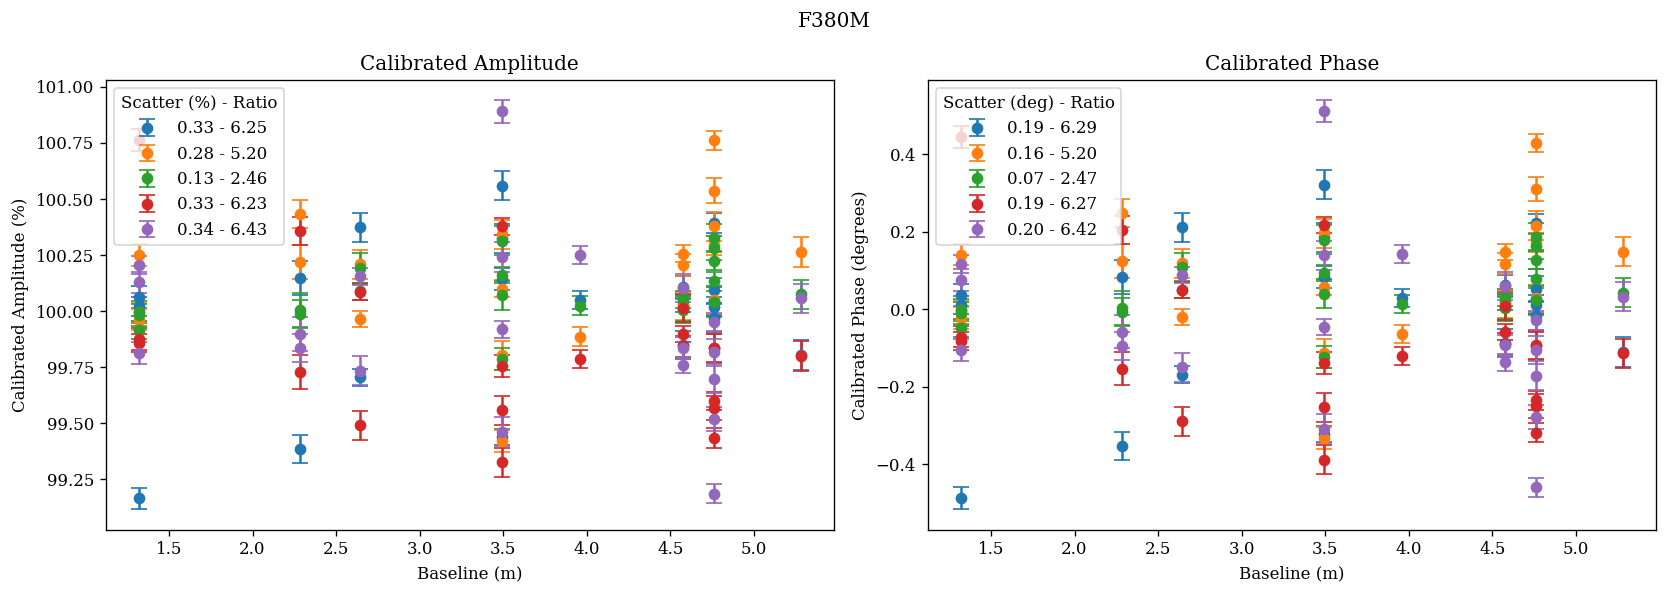

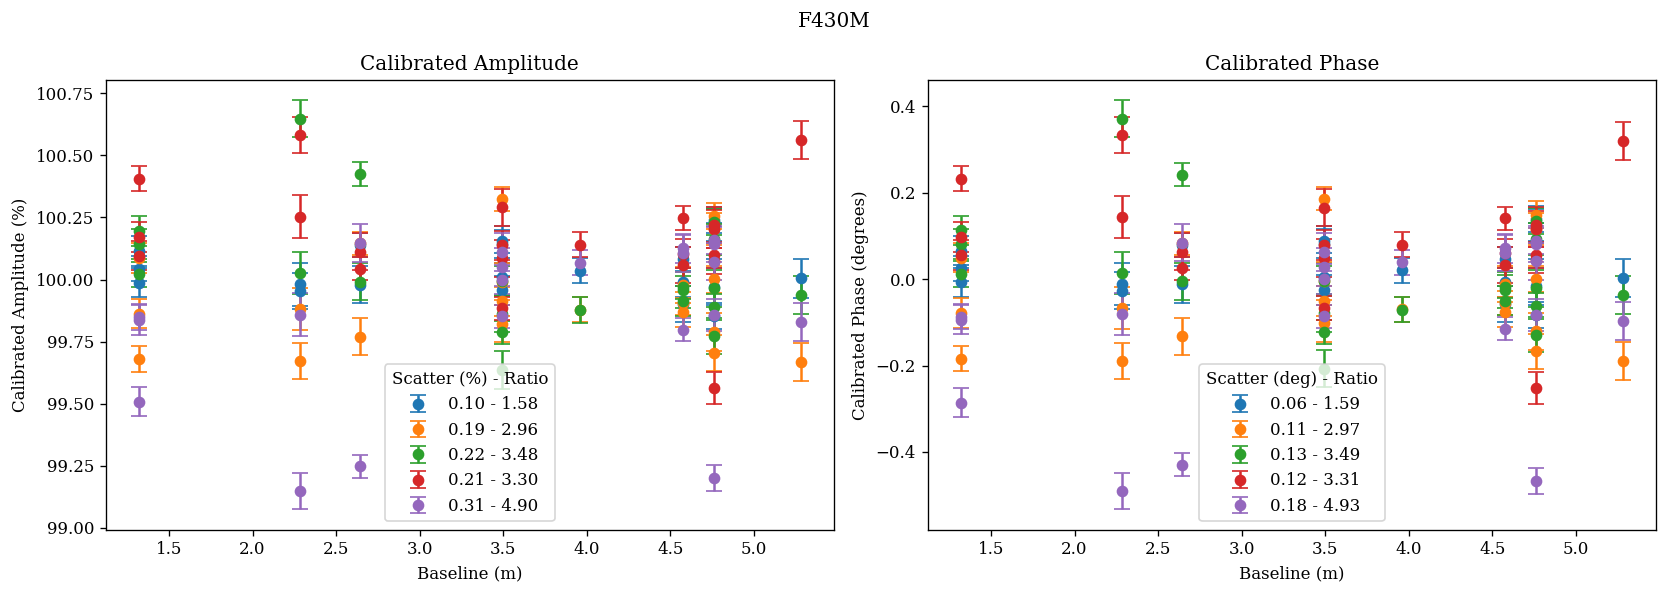

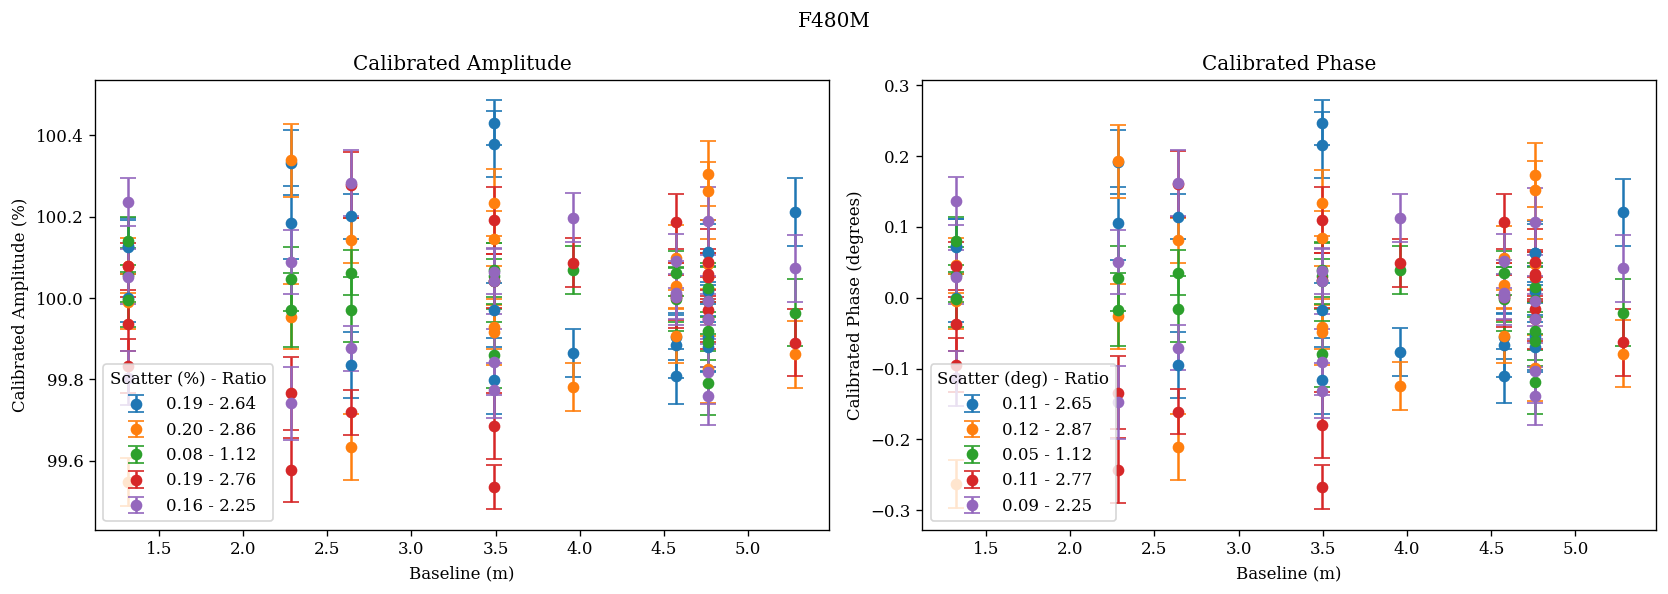

In [387]:
errorbar = lambda xs, ys, err, **kwargs: plt.errorbar(
    xs, ys, yerr=err, marker="o", capsize=5, linestyle="", **kwargs
)

ratio = 1 / 0.85

for filt in calibrated_vis.keys():
    vis_dict = calibrated_vis[filt]
    err_dict = calibrated_vis_err[filt]

    plt.figure(figsize=(14, 5))
    plt.suptitle(filt)
    plt.subplot(1, 2, 1)
    plt.title("Calibrated Amplitude")
    plt.xlabel("Baseline (m)")
    plt.ylabel("Calibrated Amplitude (%)")
    for vis, err in zip(vis_dict.values(), err_dict.values()):
        amp = 100 * np.abs(vis)
        amp_err = ratio * 100 * np.abs(err)

        scatter, mean_err = amp.std(), amp_err.mean()
        err_ratio = scatter / mean_err
        errorbar(
            rs, amp, amp_err, label=f"{scatter:.2f} - {err_ratio:.2f}"
        )
    plt.legend(title="Scatter (%) - Ratio")

    plt.subplot(1, 2, 2)
    plt.title("Calibrated Phase")
    plt.xlabel("Baseline (m)")
    plt.ylabel("Calibrated Phase (degrees)")
    for vis, err in zip(vis_dict.values(), err_dict.values()):
        pha = dlu.rad2deg(np.angle(vis))
        pha_err = ratio * dlu.rad2deg(np.angle(err))

        scatter, mean_err = pha.std(), pha_err.mean()
        err_ratio = scatter / mean_err
        errorbar(rs, pha, pha_err, label=f"{scatter:.2f} - {err_ratio:.2f}")

    plt.legend(title="Scatter (deg) - Ratio")

    plt.tight_layout()
    plt.show()

In [189]:
import time
from amigo.stats import posterior
from amigo.fisher import hessian
from tqdm.notebook import tqdm

inds = [
    flat_bls_inds,
    flat_bls_inds_dilate,
    flat_bls_inds_corner,
    flat_bls_inds_double_dilate,
]

times = []
hessians = []

exp = exposures[0]

for inds_in in tqdm(inds):
    N = len(inds_in[0])
    X = np.zeros(2*N)


    # Build function to calculate FIM and calculate
    def loglike_fn_vec(X):
        amplitudes = final_model.amplitudes[exp.key].at[*inds_in].add(X[:N])
        phases = final_model.phases[exp.key].at[*inds_in].add(X[N:])
        pytree = final_model.set(
            [f"amplitudes.{exp.key}", f"phases.{exp.key}"], [amplitudes, phases]
        )
        return posterior(pytree, exp, per_pix=False)

    t0 = time.time()
    hessians.append(hessian(loglike_fn_vec, X))
    times.append(time.time() - t0)


  0%|          | 0/4 [00:00<?, ?it/s]

In [211]:
totals = []
for t in times:
    totals.append((t // 60) + (t % 60) / 60)
totals

[1.9735512018203736, 9.089304383595785, 16.32260841925939, 22.45922210216522]

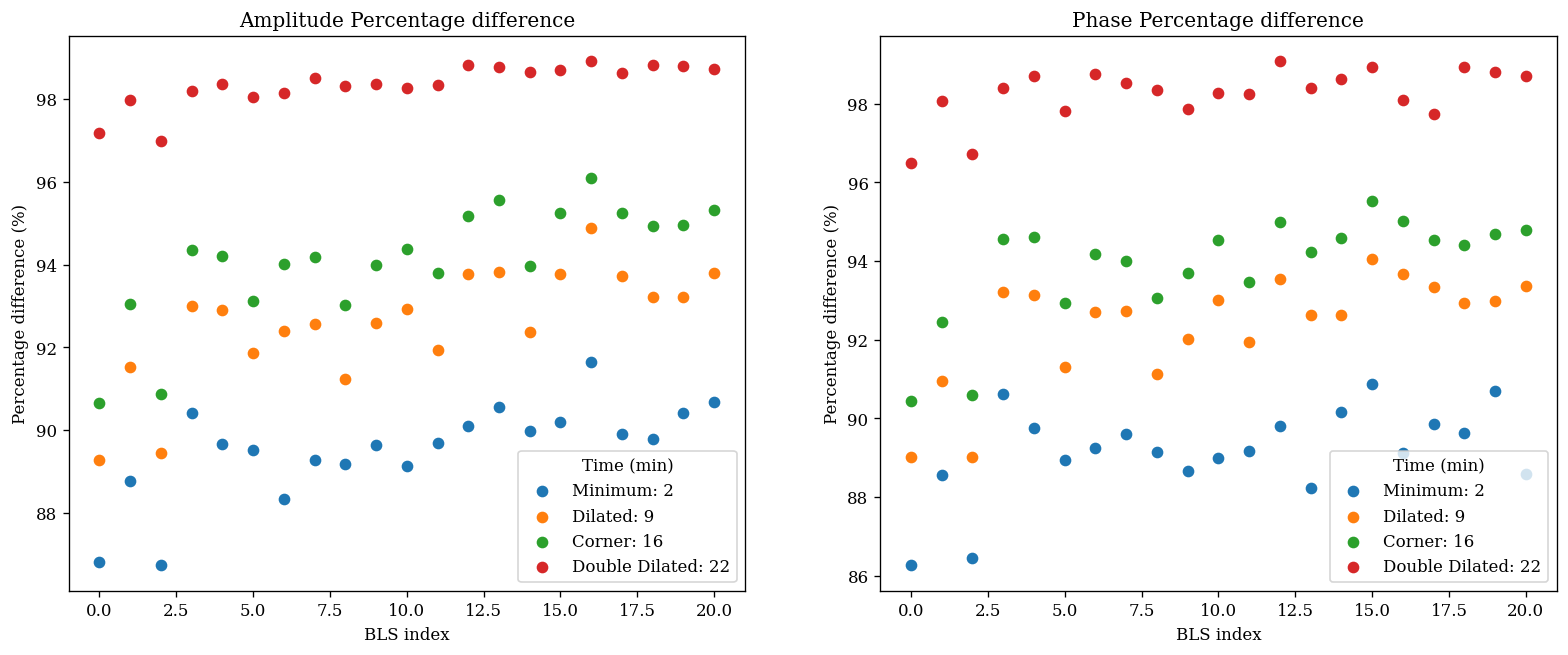

In [216]:
amp_errs = (amp_err[exposures[0].key][*flat_bls_inds])
pha_errs = (pha_err[exposures[0].key][*flat_bls_inds])
bl_ind = np.arange(len(amp_errs))

labels = ["Minimum", "Dilated", "Corner", "Double Dilated"]

plt.figure(figsize=(16, 6))

for inds_in, hess, label, t in zip(inds, hessians, labels, totals):
    null = np.zeros_like(model.amplitudes[exp.key])

    n = len(hess) // 2
    amp_hess, pha_hess = hess[:n, :n], hess[n:, n:]
    # full_errs = (np.diag(-np.linalg.inv(hess)) ** 0.5)
    amp_err_vec = (np.diag(-np.linalg.inv(amp_hess)) ** 0.5)
    pha_err_vec = (np.diag(-np.linalg.inv(pha_hess)) ** 0.5)

    # amp_err_vec = full_errs[:len(full_errs) // 2]
    # pha_err_vec = full_errs[len(full_errs) // 2:]

    amp_err_vec = null.at[*inds_in].set(amp_err_vec)
    pha_err_vec = null.at[*inds_in].set(pha_err_vec)

    reduced_amp_err = amp_err_vec[*flat_bls_inds]
    reduced_pha_err = pha_err_vec[*flat_bls_inds]

    plt.subplot(1, 2, 1)
    plt.title("Amplitude Percentage difference")
    plt.ylabel("Percentage difference (%)")
    plt.xlabel("BLS index")
    plt.scatter(bl_ind, 100 * reduced_amp_err / amp_errs, label=f"{label}: {t:.0f}")
    plt.legend(title="Time (min)")


    plt.subplot(1, 2, 2)
    plt.title("Phase Percentage difference")
    plt.ylabel("Percentage difference (%)")
    plt.xlabel("BLS index")
    plt.scatter(bl_ind, 100 * reduced_pha_err / pha_errs, label=f"{label}: {t:.0f}")
    plt.legend(title="Time (min)")

plt.show()